# Exploring the data

In [112]:
import random
import re
from pathlib import Path
from typing import Mapping, Sequence

from IPython.display import display
import matplotlib.pyplot as plt
import music21
from midi_set_class.notation import (
    ABC_PATTERN,
    abc_to_midipitch,
    midipitch_to_abc,
)
import numpy as np
import pandas as pd
import seaborn as sns

from plotting import countplot_with_numbers, barplot_with_numbers
from double_jig_gen.data import ABCDataset

In [2]:
filename = "DoubleJig0001-0365.abc"
data_url = f"http://www.norbeck.nu/abc/book/oneills/1001/{filename}"
data_path = Path("..", "data")
file_path = Path(data_path, filename)

In [3]:
assert file_path.exists(), (
    f"Download {filename} and put it in the data_path. You can go to the home dir and "
    f"execute: wget {data_url} -P data/"
)

# Raw data

The file is just a text file containing the data and metadata

In [4]:
! head -58 {str(file_path)}
! echo ...

% These tunes are from "The Dance Music of Ireland", published by Francis O'Neill in 1907.
% They were originally transcribed in ABC format by Frank Nordberg (frnordbe@online.no) and
% hosted at his site www.musicaviva.com
% That site is down since July 2019, so the tunes were fetched from John Chambers' mirror
% at http://trillian.mit.edu/~jc/music/book/oneills/1001/ where he had also corrected some errors.
% Henrik Norbeck has then proofread the ABC format tunes against the original book and corrected
% more errors. Henrik Norbeck has also made the following changes:
% - removed all m: fields (non-standard ABC and is not in the original book)
% - replaced "  ~"N by ~ to stick closer to the original book and the ABC standard.
% - changed W to S (for Segno) to adhere to the ABC standard.
% - removed two comments which were not part of the original book
% - changed transcription comments using % to W: for consistency
% - removed C:anon. which is true for most tunes, but not for others
%

## Music21

The package [music21](http://web.mit.edu/music21/doc/) can read the whole lot into a container class.

In [5]:
# This is a class containing all the separate jigs
oneills_opus = music21.converter.parse(str(file_path.resolve()))

In [6]:
# contains 365 scores as expected
len(list(oneills_opus.scores))

365

In [7]:
# All scores have a single part
sum(len(list(score.parts.stream())) for score in oneills_opus.scores)

365

## A random jig

In [8]:
random.seed(1337)
score = random.choice(oneills_opus.scores)

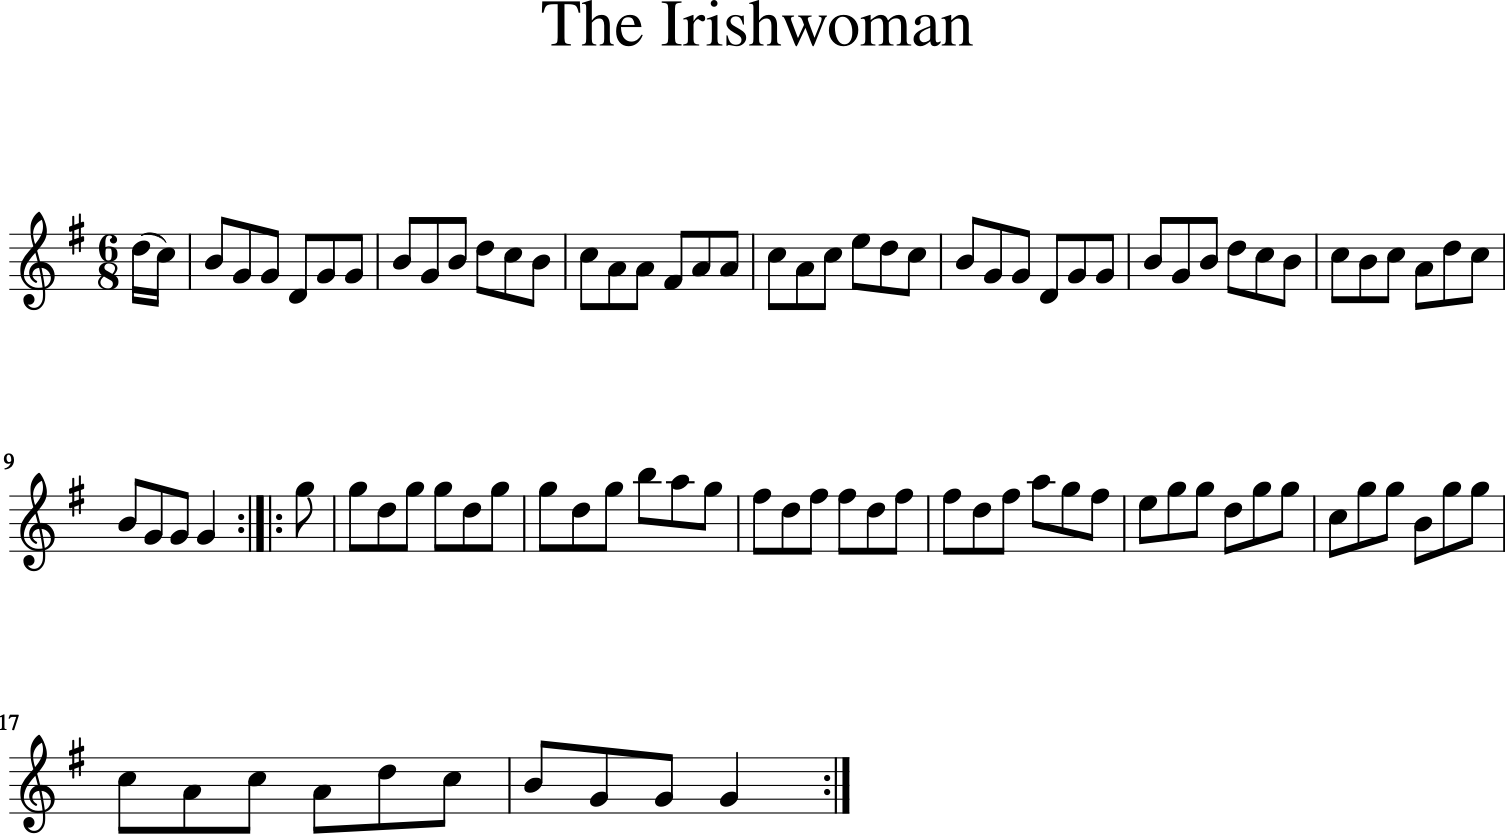

In [9]:
score.show()

## The Piper's Picnic

In [10]:
# You can select by title
score = oneills_opus.getScoreByTitle("The piper's picnic")

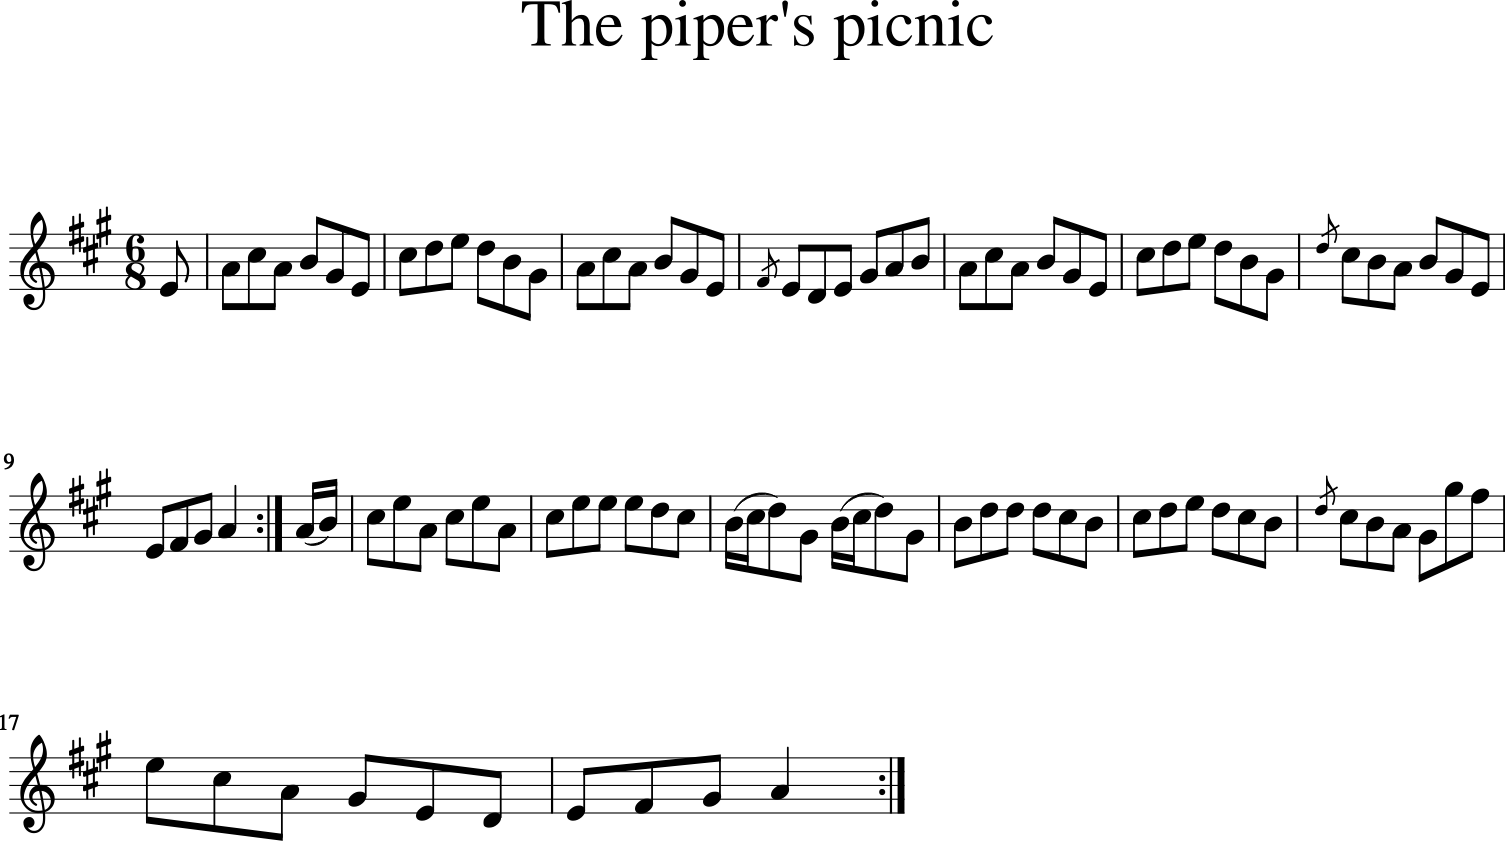

In [11]:
score.show()

Internally, music21 is storing the data as a stream of information:
* Parts contain
    * Measures which contain
        * Notes
        * and other stuff

In [12]:
score.show('text')

{0.0} <music21.metadata.Metadata object at 0x7fa32246fb50>
{0.0} <music21.stream.Part 0x7fa32246fca0>
    {0.0} <music21.stream.Measure 0 offset=0.0>
        {0.0} <music21.clef.TrebleClef>
        {0.0} <music21.key.Key of A major>
        {0.0} <music21.meter.TimeSignature 6/8>
        {0.0} <music21.note.Note E>
    {0.5} <music21.stream.Measure 1 offset=0.5>
        {0.0} <music21.note.Note A>
        {0.5} <music21.note.Note C#>
        {1.0} <music21.note.Note A>
        {1.5} <music21.note.Note B>
        {2.0} <music21.note.Note G#>
        {2.5} <music21.note.Note E>
    {3.5} <music21.stream.Measure 2 offset=3.5>
        {0.0} <music21.note.Note C#>
        {0.5} <music21.note.Note D>
        {1.0} <music21.note.Note E>
        {1.5} <music21.note.Note D>
        {2.0} <music21.note.Note B>
        {2.5} <music21.note.Note G#>
    {6.5} <music21.stream.Measure 3 offset=6.5>
        {0.0} <music21.note.Note A>
        {0.5} <music21.note.Note C#>
        {1.0} <music21.note.No

## Extracting metadata

Here's what The Piper's Picnic looks like in the raw dataset

```
X:2
T:The piper's picnic
O:Ireland
B:Francis O'Neill: "The Dance Music of Ireland" (1907) no. 2
R:Double jig
Z:Transcribed by Frank Nordberg - http://www.musicaviva.com
F:http://www.musicaviva.com/abc/tunes/ireland/oneill-1001/oneill-1001-0002.abc
M:6/8
L:1/8
K:A
E|AcA BGE|cde dBG|\
AcA BGE|{F}EDE GAB|AcA BGE|cde dBG|{d}cBA BGE|EFG A2:|
(A/B/)|ceA ceA|cee edc|(B/c/d)G (B/c/d)G|Bdd dcB|\
cde dcB|{d}cBA Ggf|ecA GED|EFGA2:|
```

We can get (most of) that data using music21

In [13]:
meta = score.metadata
# there is only one part to each jig so index 0 works
first_measure = score.parts[0].measure(0)
second_measure = score.parts[0].measure(1)

In [14]:
# for attr_name in meta.searchAttributes:
#     print(f"{attr_name}: {getattr(meta, attr_name)}")

('2',
 "The piper's picnic",
 'Ireland',
 None,
 None,
 None,
 None,
 '<music21.meter.TimeSignature 6/8>',
 0.5,
 'A major',
 None)

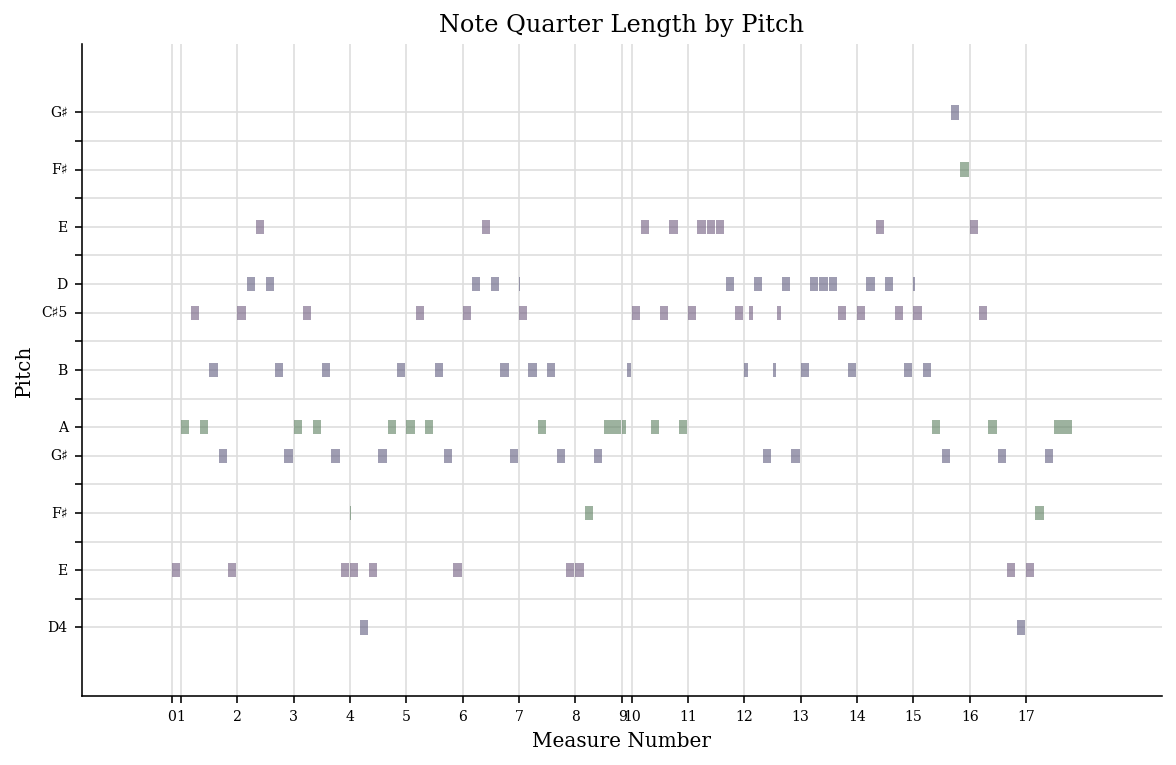

In [15]:
(
    meta.number,  # X:2
    meta.title,  # T:The piper's picnic
    meta.localeOfComposition,  # O:Ireland
    None,  # B:Francis O'Neill: "The Dance Music of Ireland" (1907) no. 2
    None,  # R:Double jig
    None,  # Z:Transcribed by Frank Nordberg - http://www.musicaviva.com
    None,  # F:http://www.musicaviva.com/abc/tunes/ireland/oneill-1001/oneill-1001-0002.abc
    str(first_measure.timeSignature),  # M:6/8
    second_measure.offset,  # L:1/8
    str(first_measure.keySignature), # K:A
    score.plot(),  # E|AcA BGE|cde dBG|\
           # AcA BGE|{F}EDE GAB|AcA BGE|cde dBG|{d}cBA BGE|EFG A2:|
           # (A/B/)|ceA ceA|cee edc|(B/c/d)G (B/c/d)G|Bdd dcB|\
           # cde dcB|{d}cBA Ggf|ecA GED|EFGA2:|
)

# DQA

In [16]:
with open(file_path, 'r') as fh:
    # remove comments
    data_lines = [line for line in fh.readlines() if not line.startswith("%")]
    # remove leading and trailing whitespace and recombine
    data = "".join(data_lines).strip()

In [17]:
abc_strings = data.split("\n\n\n\n")

In [18]:
len(abc_strings)  # this should be 365

365

In [19]:
# Taken from: http://abcnotation.com/wiki/abc:standard:v2.1
ABC_FIELDS = {
    'A': 'area',
    'B': 'book',
    'C': 'composer',
    'D': 'discography',
    'F': 'file url',
    'G': 'group',
    'H': 'history',
    'I': 'instruction',
    'K': 'key',
    'L': 'unit note length',
    'M': 'meter',
    'm': 'macro',
    'N': 'notes',
    'O': 'origin',
    'P': 'parts',
    'Q': 'tempo',
    'R': 'rhythm',
    'r': 'remark',
    'S': 'source',
    's': 'symbol line',
    'T': 'tune title',
    'U': 'user defined',
    'V': 'voice',
    'W': 'words',
    'w': 'words',
    'X': 'reference number',
    'Z': 'transcription'
}


def merge_continuation_lines(lines: Sequence[str]) -> Sequence[str]:
    """Merges lines which end with \ with the next line.
    
    Args:
        lines: a list of strings to check and merge.
        
    Returns:
        lines: the list of strings which have been merged.
    """
    nr_checks = len(lines)
    idx = 0
    for _ in range(nr_checks):
        line = lines[idx]
        if line.endswith("\\"):
            line = line[:-1]  # remove trailing backslash
            try:
                lines[idx] = f"{line} {lines[idx+1]}"
                del lines[idx+1]  # del and stay on this line
            except IndexError as e:
                print(lines, line)
                raise e
        else:
            idx += 1
    return lines


def parse_abc(abc_str: str) -> Mapping[str, str]:
    """Get the required information from each tune.
    
    Extracts the metadata as defined in [1] from the string, plus the transcription
    which is assumed not to have a prefix. Assumes all metadata is stated before the
    transcription is started. Then adds everything remaining to the transcription.
    
    Args:
        abc_str: the string containing an abc file to parse.
        
    Returns:
        out_dict: a dictionary containing all the extracted values.
    
    See also:
    * http://abcnotation.com/wiki/abc:standard:v2.1
    """
    lines = [line.strip() for line in abc_str.split("\n")]
    
    # if a line ends with \ then merge with subsequent line
    lines = merge_continuation_lines(lines)
    
    valid_field = "|".join(ABC_FIELDS)
    metadata_line_regex = re.compile(f"^({valid_field}):")
     
    _, metadata_end_idx = min(
        (val, idx)
        for (idx, val)
        in enumerate([bool(metadata_line_regex.match(line)) for line in lines])
    )
    
    out_dict = {}
    for line in lines[:metadata_end_idx]:
        meta_key, value = line.split(":", 1)
        field_name = ABC_FIELDS[meta_key]
        if field_name in out_dict:
            concat_fields = ("tune title", "words")
            if field_name not in concat_fields:
                msg = (
                    f"Tried to add {(field_name, value)} to {out_dict}."
                    f"\nLines: {lines}"
                )
                raise ValueError(msg)
            else:
                out_dict[field_name] = f"{out_dict[field_name]} --- {line}"
        out_dict[field_name] = value
    
    transcription_label = "tune"
    for line in lines[metadata_end_idx:]:
        if line.upper().startswith("W:"):
            if "words" not in out_dict:
                out_dict["words"] = line
            else:
                out_dict["words"] = f"{out_dict['words']} --- {line}"
        elif transcription_label not in out_dict:
            out_dict[transcription_label] = line
        else:
            out_dict[transcription_label] = f"{out_dict[transcription_label]} {line}"
    return out_dict

In [20]:
parsed_abc = [parse_abc(abc) for abc in abc_strings]

In [21]:
oneills_df = pd.DataFrame(parsed_abc)

### How much of the data is missing?

In [22]:
missing_counts = oneills_df.isna().sum().rename("count_of_missing_values")
missing_counts

reference number      0
tune title            0
origin                0
book                  0
rhythm                0
transcription         0
file url              0
meter                 0
unit note length      0
key                   0
tune                  0
words               357
Name: count_of_missing_values, dtype: int64

In [23]:
id_vars = ["reference number"]
value_vars = [col for col in oneills_df.columns if col not in id_vars]
melt_df = oneills_df.melt(
    id_vars=id_vars,
    value_vars=value_vars,
    var_name="field_name",
)
missing_df = melt_df
missing_df["value"] = missing_df["value"].isna()

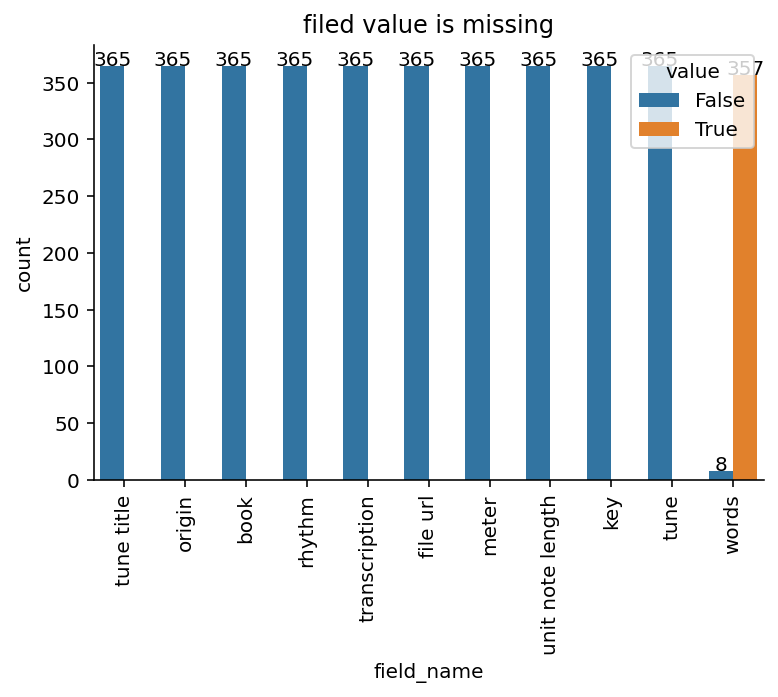

In [24]:
countplot_with_numbers(
    var_name="field_name", data=missing_df,  hue="value", kind="count"
)
plt.title("filed value is missing")
plt.xticks(rotation=90);

In [25]:
def ordered_countplot(series, **kwargs):
    count = series.value_counts()
    barplot_with_numbers(count, **kwargs)

### Vaule counts

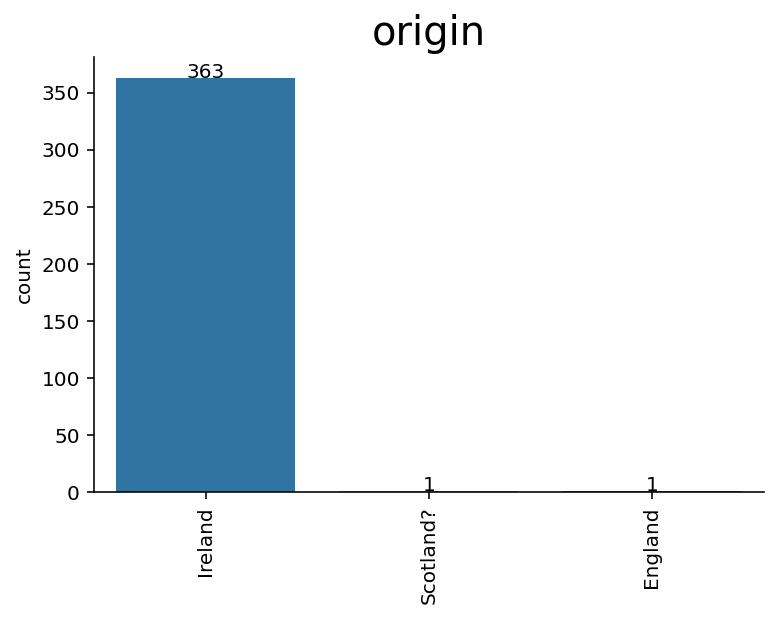

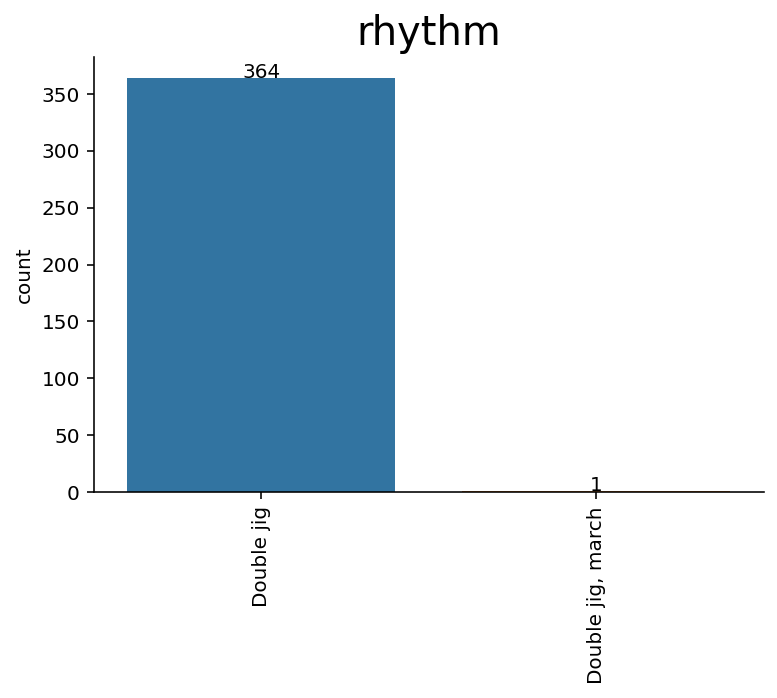

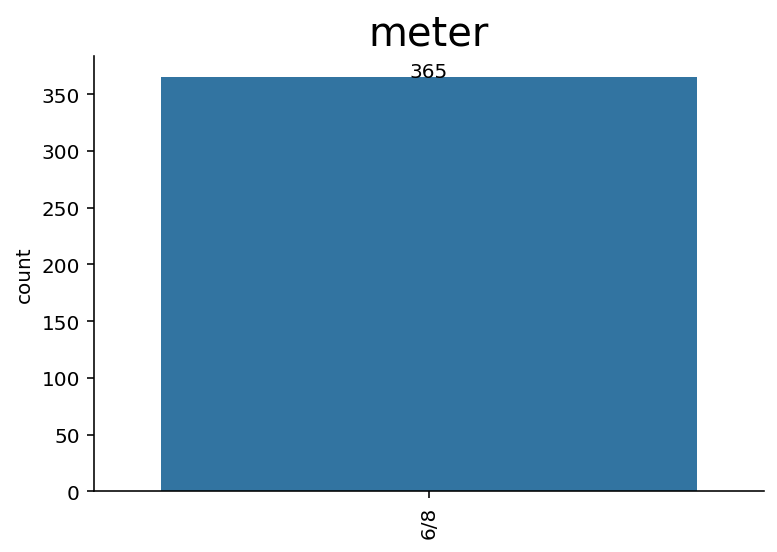

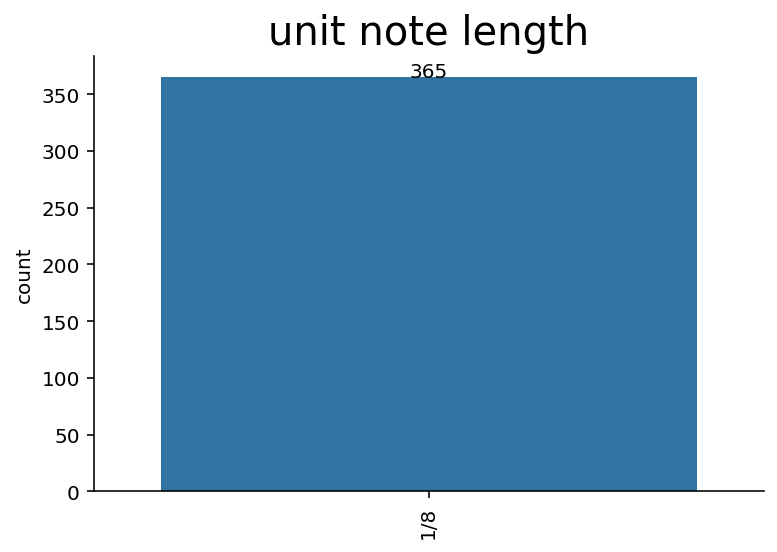

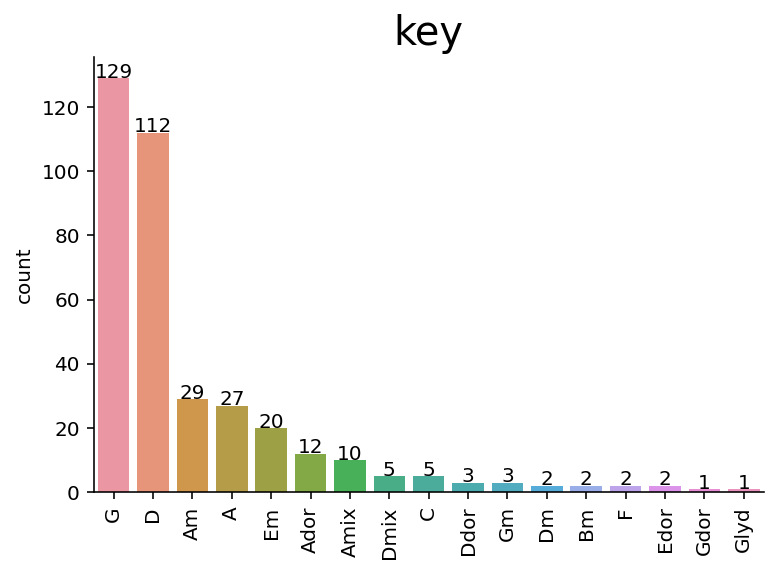

In [26]:
exclude_cols = [
    "reference number",
    "tune title",
    "file url",
    "book",
    "tune",
    "words",
    "transcription",
]
for col in [col for col in oneills_df.columns if col not in exclude_cols]:
    plt.figure()
    ordered_countplot(oneills_df[col], kind="count")
    plt.xticks(rotation=90)
    plt.title(col, fontsize=20)
    plt.ylabel("count")
    plt.show()

In [27]:
oneills_df["book"].str.slice(
    stop=len("Francis O'Neill: 'The Dance Music of Ireland' (1907)")
).value_counts()

Francis O'Neill: "The Dance Music of Ireland" (1907)    365
Name: book, dtype: int64

In [28]:
for idx in oneills_df.index[~oneills_df["words"].isna()]:
    ref, title, words = oneills_df.loc[idx, ["reference number", "tune title", "words"]]
    comment = "\n".join(words.split(" --- "))
    print(f"Tune {ref} \"{title}\", has comments:\n{comment}\n")

Tune 30 "Welcome to Cork", has comments:
W:
W:added = for f in bar 11

Tune 117 "The highlander", has comments:
W:
W:1) Org. not dotted.

Tune 154 "The Antrim lasses", has comments:
W:
W:Bar 10-11: Originally a mixture of g naturals and g sharps:
W:gfg =G2g|=gfg G2B

Tune 250 "Paddy in London", has comments:
W:
W:Bar 12, last note (chord) org. 4th note

Tune 264 "The banks of Lough Gowna", has comments:
W:
W:Last note on each line org. not dotted

Tune 333 "Miss Downing's fancy", has comments:
W:
W:1) org. not dotted.

Tune 361 "The Drogheda weavers", has comments:
W:
W:Bar 8 last note org. 4th note

Tune 365 "Merry Mary", has comments:
W:
W:1) Org. not dotted.



## Tune analysis

In [29]:
tunes = [abc["tune"] for abc in parsed_abc]

In [30]:
tokens_set = set(list(''.join(tunes)))
idx2token = list(tokens_set)
vocab_size = len(idx2token)
print(f"vocabulary size: {vocab_size}")
print(f"vocabulary (each token separated by a space): \n{' '.join(sorted(tokens_set))}")

vocabulary size: 48
vocabulary (each token separated by a space): 
  " ' ( ) , - . / 1 2 3 4 : < = > A B C D E F G H K L M S T [ ] ^ _ a b c d e f g s t z { | } ~


### Number of tokens in a piece (not true length as repeats are notated |: :|)

In [31]:
tune_len = [len(tune.replace(' ', '')) for tune in tunes]

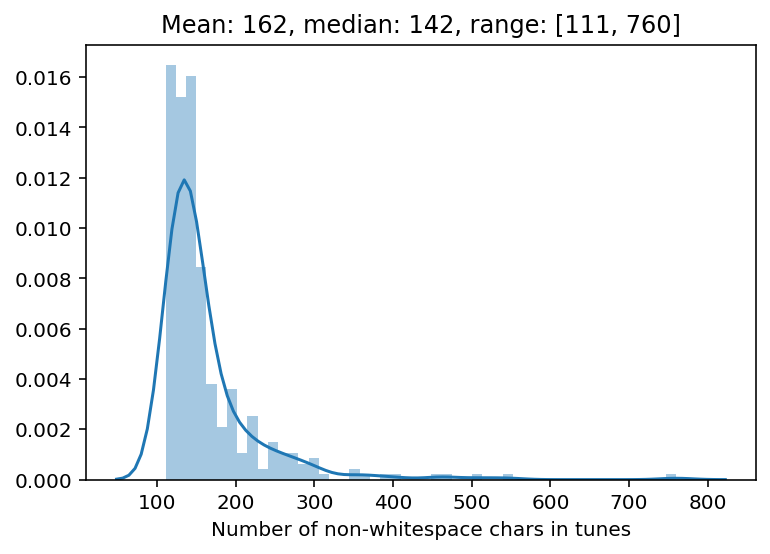

In [32]:
max_len = max(tune_len)
med_len = np.median(tune_len)
mean_len = np.mean(tune_len)
min_len = min(tune_len)
sns.distplot(tune_len)
plt.xlabel("Number of non-whitespace chars in tunes")
plt.title(
    f"Mean: {int(mean_len)}, median: {int(med_len)}, range: [{min_len}, {max_len}]"
);

### How many tunes have ornamentation etc. in them?

Summary:

* K - key change mid tune
* L - a `>` accent on the subsequent note
* M - a lower mordent <img src="https://www.8notes.com/school/lessons/all/lowermordent1.1.gif" alt="Lower Mordent" width=200>
* S, and O - segno (sign), and coda <img src="https://www.liveabout.com/thmb/1Qfs7xts_x04z1HXOWLPeibyivA=/735x0/GL_segno-coda-music-56a72d345f9b58b7d0e7996b.png" alt="segno" width="100"/>
* T - `tr' trill
* ~ - irish roll
* z - rest
* { } - grace note
* "..." - text annotations

For more on these, see http://abcnotation.com/wiki/abc:standard:v2.1

Exceptions found:
* The one tune containing 's' and 't' has a text annotation saying 1st and 2nd

I found http://www.clivew.com/abc.php useful for viewing ornaments (music21 doesn't display them).

In [33]:
query_strings = ["K", "L", "M", "S", "T", "t", "s", "~", "z", "{", "\""]
weird_tunes = {}
for query in query_strings:
    weird_tunes[query] = [
        (idx, tune) for (idx, tune) in enumerate(tunes) if query in tune
    ]

In [34]:
{k: len(v) for k, v in weird_tunes.items()}

{'K': 3,
 'L': 1,
 'M': 18,
 'S': 11,
 'T': 59,
 't': 1,
 's': 1,
 '~': 19,
 'z': 21,
 '{': 101,
 '"': 5}



========== Exceptions contiaining 'K' (3) ==========

reference number: 228
tune title: Come to dinner
origin: Ireland
book: Francis O'Neill: "The Dance Music of Ireland" (1907) no. 228
rhythm: Double jig
transcription: Transcribed by Frank Nordberg - http://www.musicaviva.com
file url: http://www.musicaviva.com/abc/tunes/ireland/oneill-1001/oneill-1001-0228.abc
meter: 6/8
unit note length: 1/8
key: Ador
tune: e|(c<A)A A2A|EAB cBA|(B<G)G G2G|BGB gdB|(c<A)A A2B|cde agf|gec Bed|(c<A)A A2:| K:A |:e|aga bag|aec Ace|dBG EGB|Acf efg|aga bag|aec Ace|dBG EGB|(c<A)A A2:|




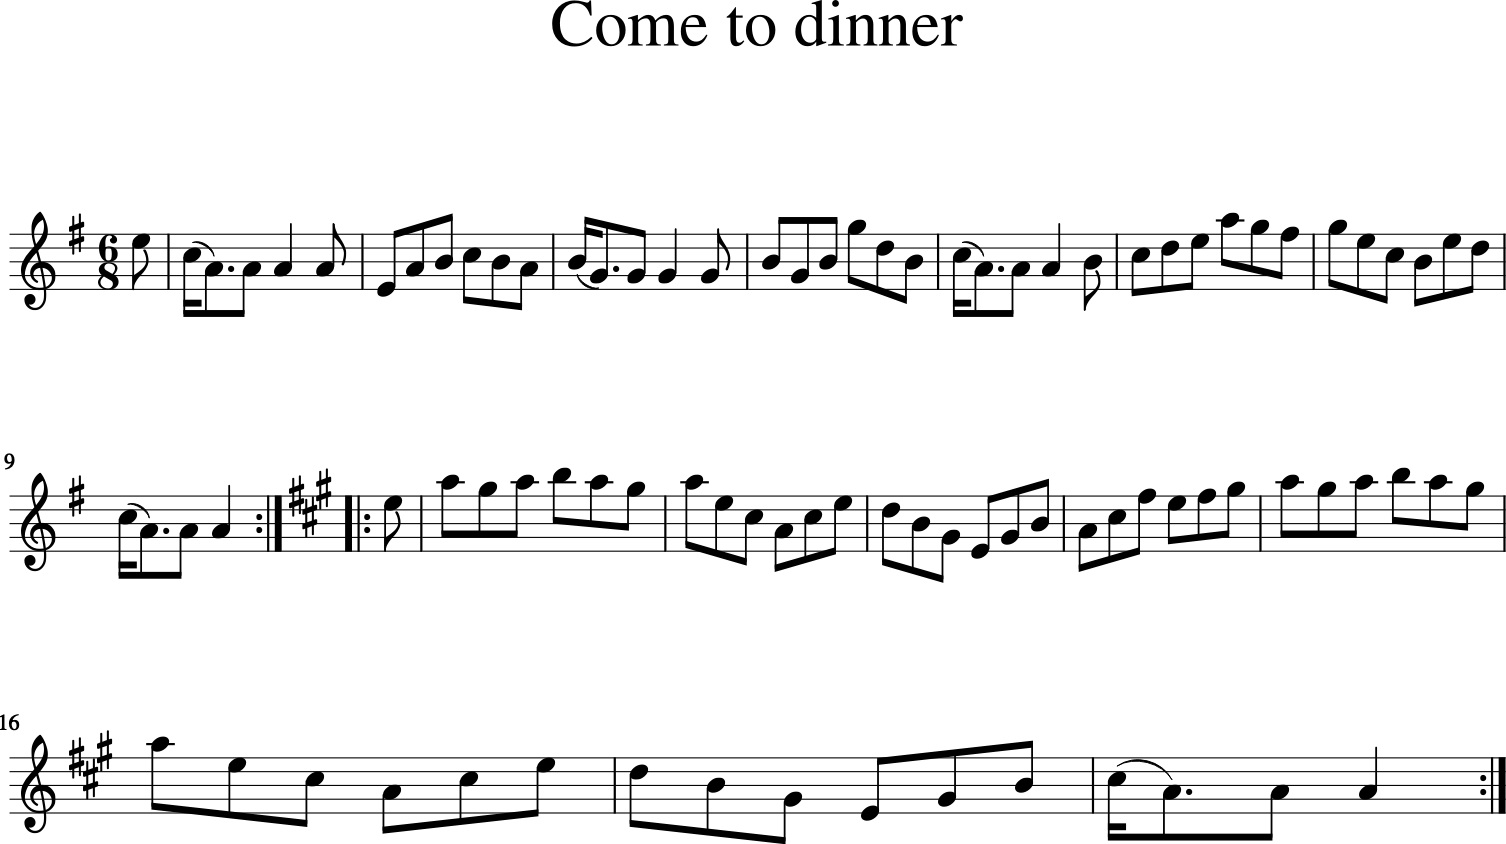




 ... 



========== Exceptions contiaining 'L' (1) ==========

reference number: 122
tune title: Charley the prayermaster
origin: Ireland
book: Francis O'Neill: "The Dance Music of Ireland" (1907) no. 122
rhythm: Double jig
transcription: Transcribed by Frank Nordberg - http://www.musicaviva.com
file url: http://www.musicaviva.com/abc/tunes/ireland/oneill-1001/oneill-1001-0122.abc
meter: 6/8
unit note length: 1/8
key: G
tune: A|GED G2A|Bee dBA|GED GAB|({d}c)BA BGE|GED G2A|Bee dBA|GED G2A|BGG G2:| |:d|e2d Le2d|efe edB|d2B Ld2B|dge dBG|e2d Le2f|{a}gfe dBA|GED G2A|BGG G2:|




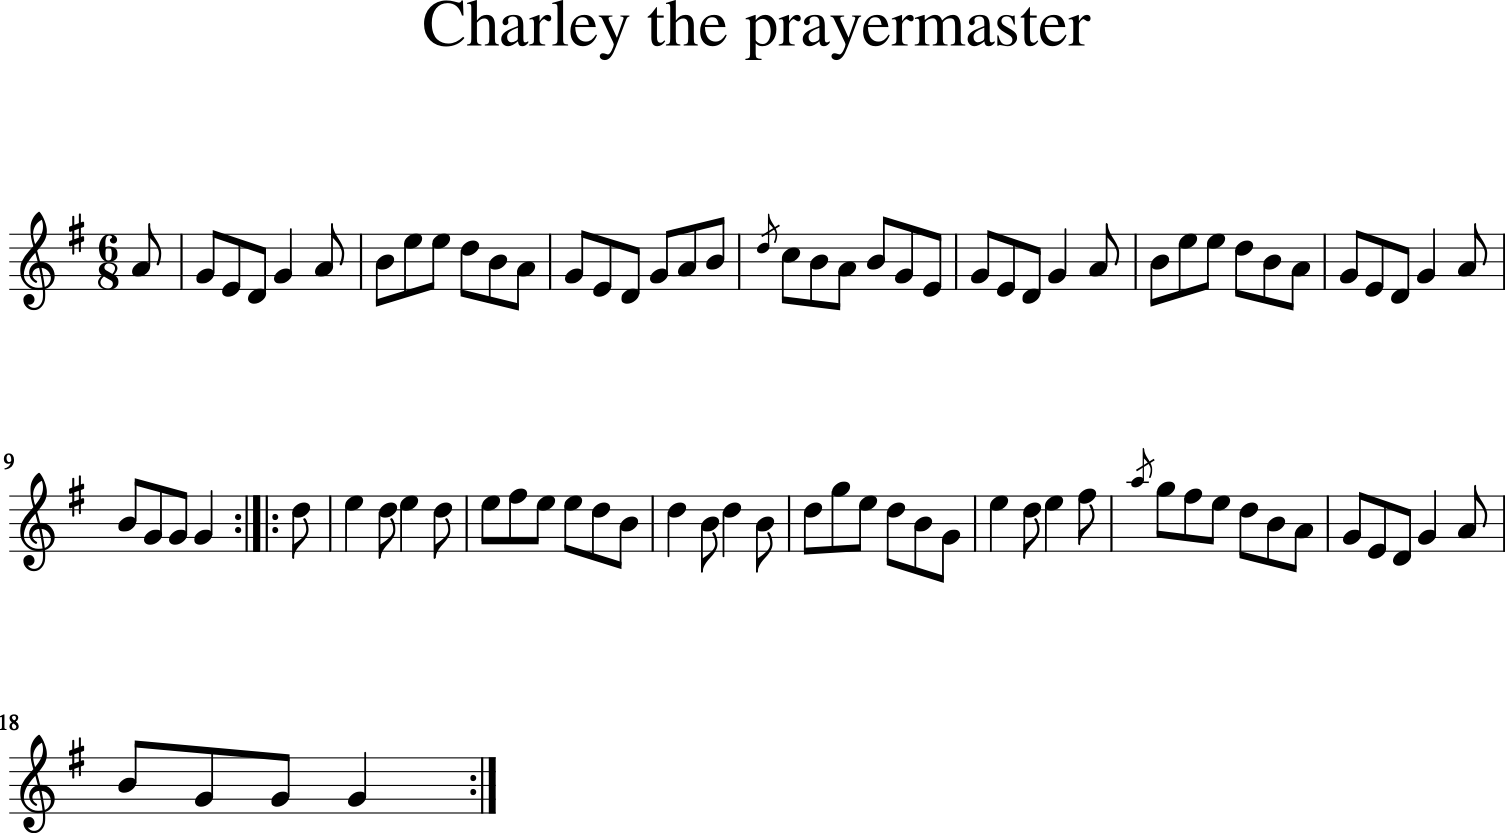





========== Exceptions contiaining 'M' (18) ==========

reference number: 12
tune title: The gold ring
origin: Ireland
book: Francis O'Neill: "The Dance Music of Ireland" (1907) no. 12
rhythm: Double jig
transcription: Transcribed by Frank Nordberg - http://www.musicaviva.com
file url: http://www.musicaviva.com/abc/tunes/ireland/oneill-1001/oneill-1001-0012.abc
meter: 6/8
unit note length: 1/8
key: G
tune: d|cAG GFG|cAG G2d|cAG GFG|cAGF2 d|cAG GFG| cAG TA2 G|FGA (Mfed)|cAG G2:|d|cAd cAd| cAG G2d|cAd cAd|cAG F2d|cAd cAd|cAG TA2G|FGA (Mfed)|cAGG2:|(3d/e/f/| gag gdc|BGGG2 d/e/|=fgf fc_B| A=FF F2d|gag gdc|BGG G2d|=fgf fed|cAG G2:|(3d/e/f/| gdd fdd|gdd fdd|gdd fdd|cAG G2 (3d/e/f/|gdd fdd| gdd fdd|(f/g/a)g f2d|cAG G2:|D|Gdd Gdd|cAG G2A|TB2G TA2G| cAG F2A|TB2G TA2G|TB2G TA2G|FGA (Mfed)| cAG G2 :| (G/A/)|BGB AFA|DED FED|Add fed|cAG FGA| BGB AFA|DED FED|Add fed|cAGG2:| |:(G/A/)|BAB DED|AFA DED|Add fed|cAG FGA|BAB DED| AFA DED|Add fed|cAGG2:|




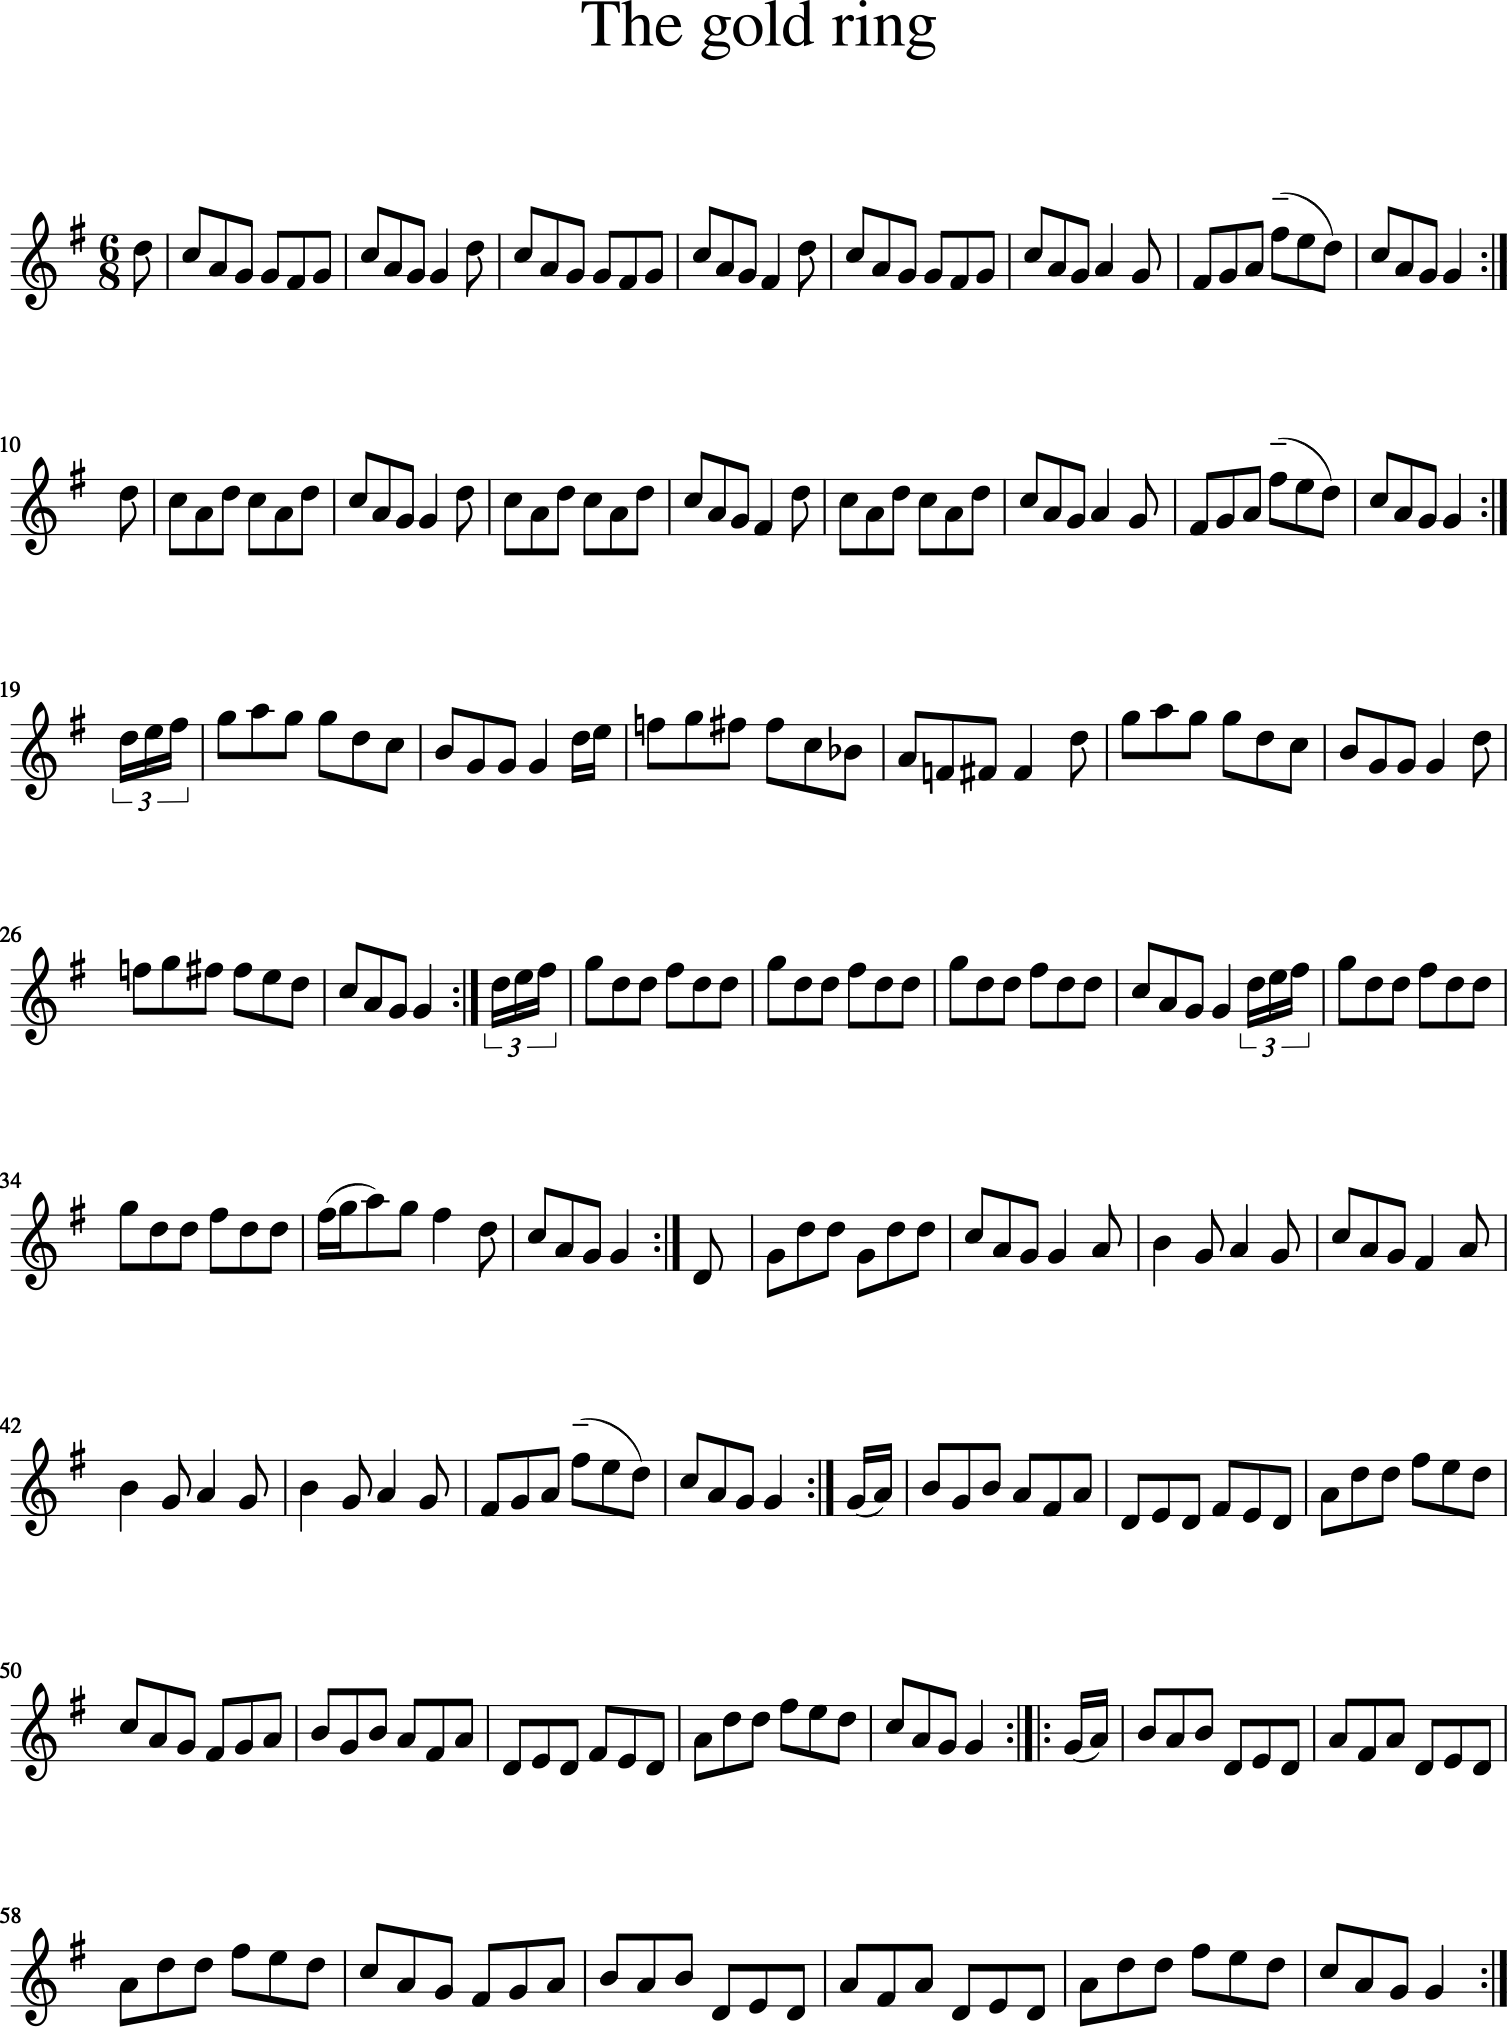




 ... 



========== Exceptions contiaining 'S' (11) ==========

reference number: 29
tune title: Cherish the ladies
origin: Ireland
book: Francis O'Neill: "The Dance Music of Ireland" (1907) no. 29
rhythm: Double jig
transcription: Transcribed by Frank Nordberg - http://www.musicaviva.com
file url: http://www.musicaviva.com/abc/tunes/ireland/oneill-1001/oneill-1001-0029.abc
meter: 6/8
unit note length: 1/8
key: D
tune: (3A/B/c/S|dFF AFF|DFA AGF|BEE GEE|GBA GFE|dFF AFF| DFA AFA|Bcd efg|fdd d2 H :|(3A/B/c/|dfd cec| dfd AGF|BEE GEE|GBA GFE|dfd cec|dfd AGF|Bcd efg| fdd d2:|A|dfd cec|dfd AGF|B z E G z E| (GBA) GFE|dGd cFc|dGd A2G|(A>Bc/d/) efg| fdd d2:| B|Add fdd|add fdd|(A/B/c)d gfg|ece gfe| agf bge|afd cBA|(3f/g/a/ B2 AGF|GEF GFE:|f2f afd| fed cde|g2g gfg|ece gfe|agf bge|afd cBA| fdB AGF|GEF GFE:|DFA dAF|DFA BGE|DFA dAF| GEF GFE|DFA DGB|DFA d2e|fdB AGF|GEF GFES:|




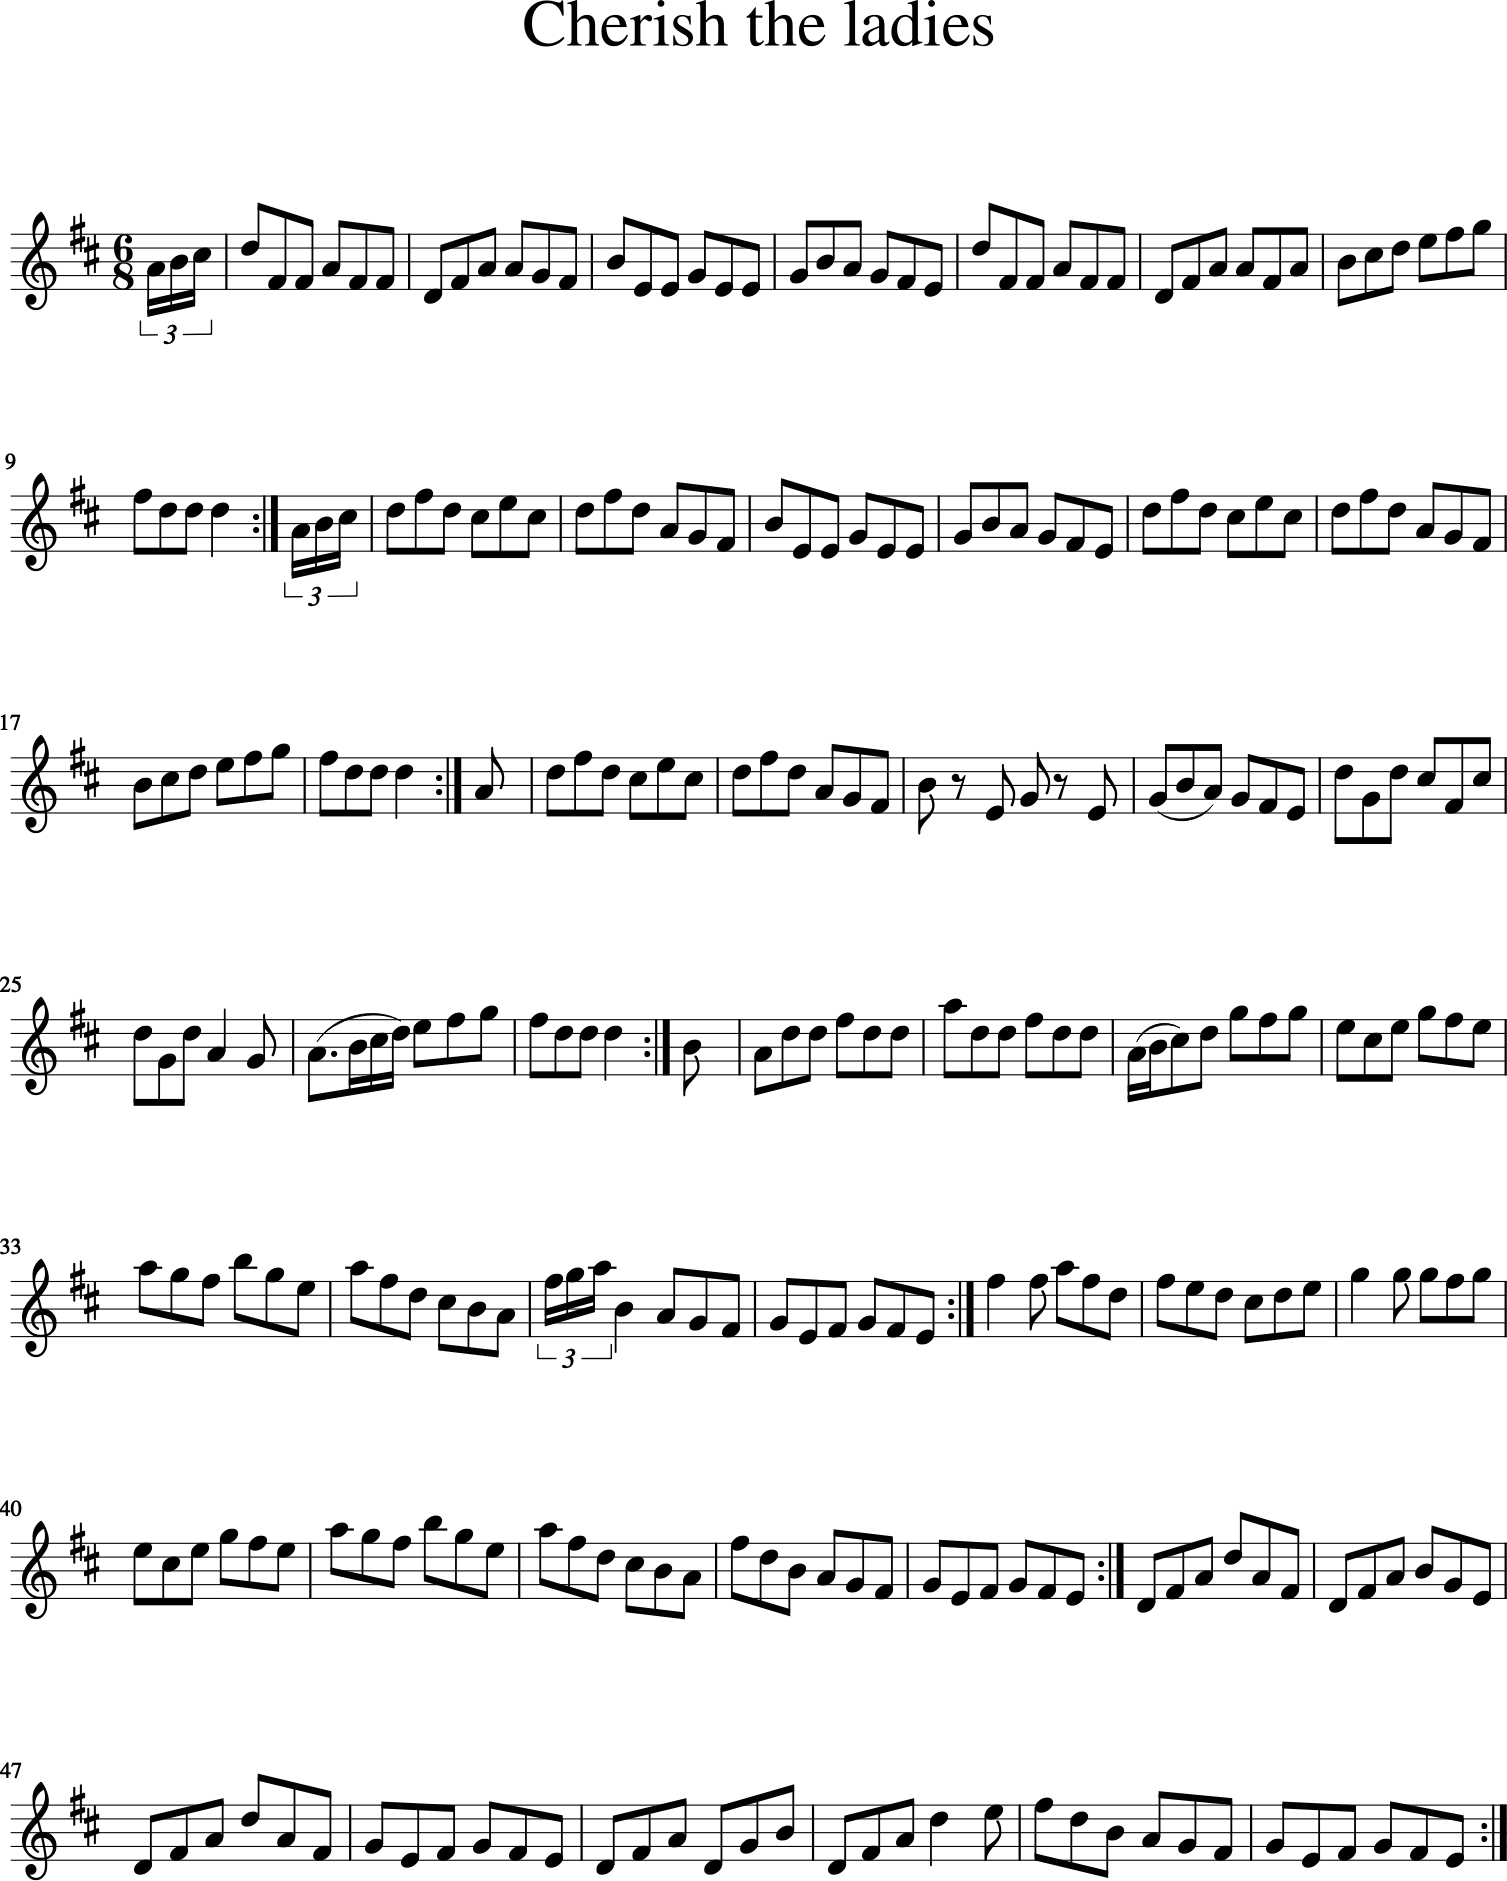




 ... 



========== Exceptions contiaining 'T' (59) ==========

reference number: 12
tune title: The gold ring
origin: Ireland
book: Francis O'Neill: "The Dance Music of Ireland" (1907) no. 12
rhythm: Double jig
transcription: Transcribed by Frank Nordberg - http://www.musicaviva.com
file url: http://www.musicaviva.com/abc/tunes/ireland/oneill-1001/oneill-1001-0012.abc
meter: 6/8
unit note length: 1/8
key: G
tune: d|cAG GFG|cAG G2d|cAG GFG|cAGF2 d|cAG GFG| cAG TA2 G|FGA (Mfed)|cAG G2:|d|cAd cAd| cAG G2d|cAd cAd|cAG F2d|cAd cAd|cAG TA2G|FGA (Mfed)|cAGG2:|(3d/e/f/| gag gdc|BGGG2 d/e/|=fgf fc_B| A=FF F2d|gag gdc|BGG G2d|=fgf fed|cAG G2:|(3d/e/f/| gdd fdd|gdd fdd|gdd fdd|cAG G2 (3d/e/f/|gdd fdd| gdd fdd|(f/g/a)g f2d|cAG G2:|D|Gdd Gdd|cAG G2A|TB2G TA2G| cAG F2A|TB2G TA2G|TB2G TA2G|FGA (Mfed)| cAG G2 :| (G/A/)|BGB AFA|DED FED|Add fed|cAG FGA| BGB AFA|DED FED|Add fed|cAGG2:| |:(G/A/)|BAB DED|AFA DED|Add fed|cAG FGA|BAB DED| AFA DED|Add fed|cAGG2:|




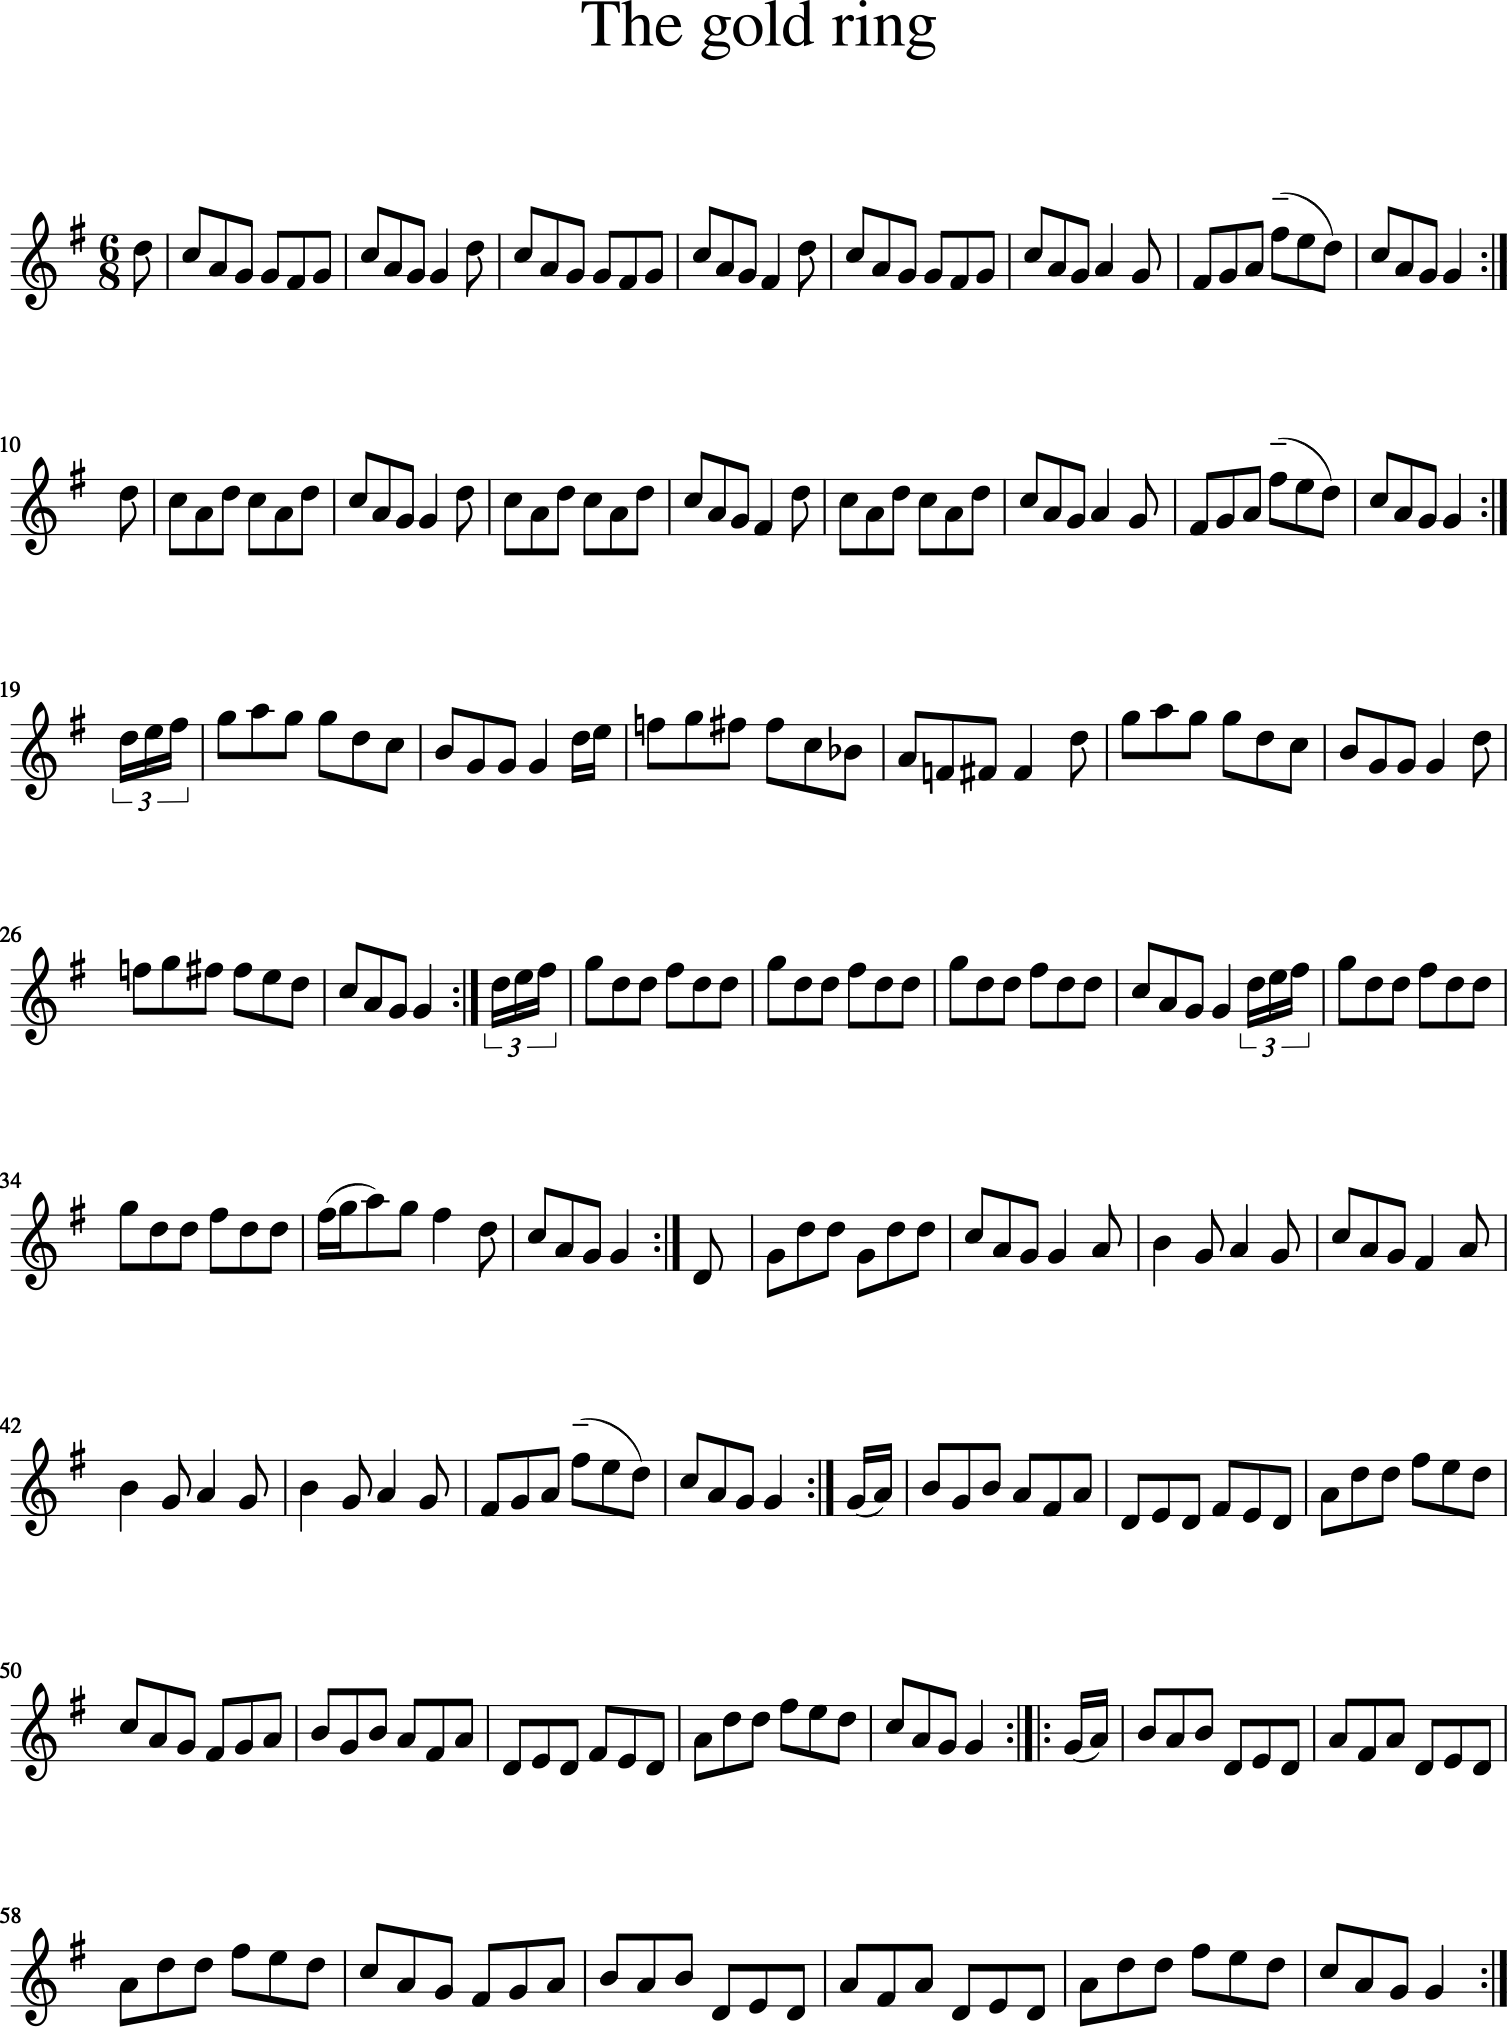




 ... 



========== Exceptions contiaining 't' (1) ==========

reference number: 78
tune title: Happy to meet and sorry to part
origin: Ireland
book: Francis O'Neill: "The Dance Music of Ireland" (1907) no. 78
rhythm: Double jig
transcription: Transcribed by Frank Nordberg - http://www.musicaviva.com
file url: http://www.musicaviva.com/abc/tunes/ireland/oneill-1001/oneill-1001-0078.abc
meter: 6/8
unit note length: 1/8
key: G
tune: g/f/S|edc BAB|GEF G2A|Bdd Bee|Bdd dge|dBG AGE|DEG G2A|Bed B2A|BGG G2:| |:e/f/|gag fed|Bdd def|gag fed|Bee e2f|gag gfe|dBd g2 "^2d""_1st"[ef]|[1 dBG AGE|DEG G2:|[2 gfg eag|fef gfeS|]




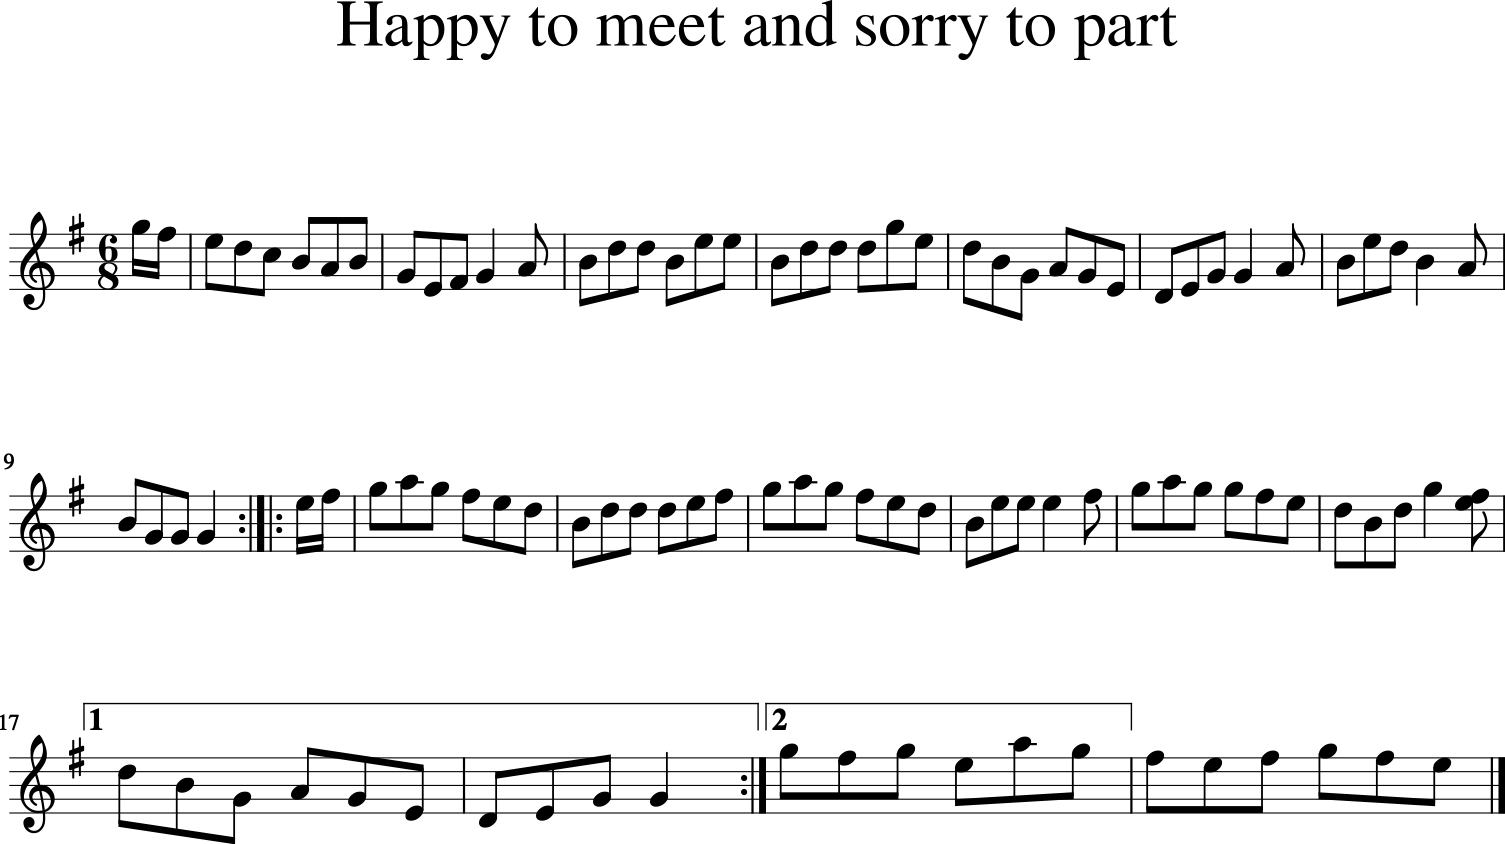





========== Exceptions contiaining 's' (1) ==========

reference number: 78
tune title: Happy to meet and sorry to part
origin: Ireland
book: Francis O'Neill: "The Dance Music of Ireland" (1907) no. 78
rhythm: Double jig
transcription: Transcribed by Frank Nordberg - http://www.musicaviva.com
file url: http://www.musicaviva.com/abc/tunes/ireland/oneill-1001/oneill-1001-0078.abc
meter: 6/8
unit note length: 1/8
key: G
tune: g/f/S|edc BAB|GEF G2A|Bdd Bee|Bdd dge|dBG AGE|DEG G2A|Bed B2A|BGG G2:| |:e/f/|gag fed|Bdd def|gag fed|Bee e2f|gag gfe|dBd g2 "^2d""_1st"[ef]|[1 dBG AGE|DEG G2:|[2 gfg eag|fef gfeS|]




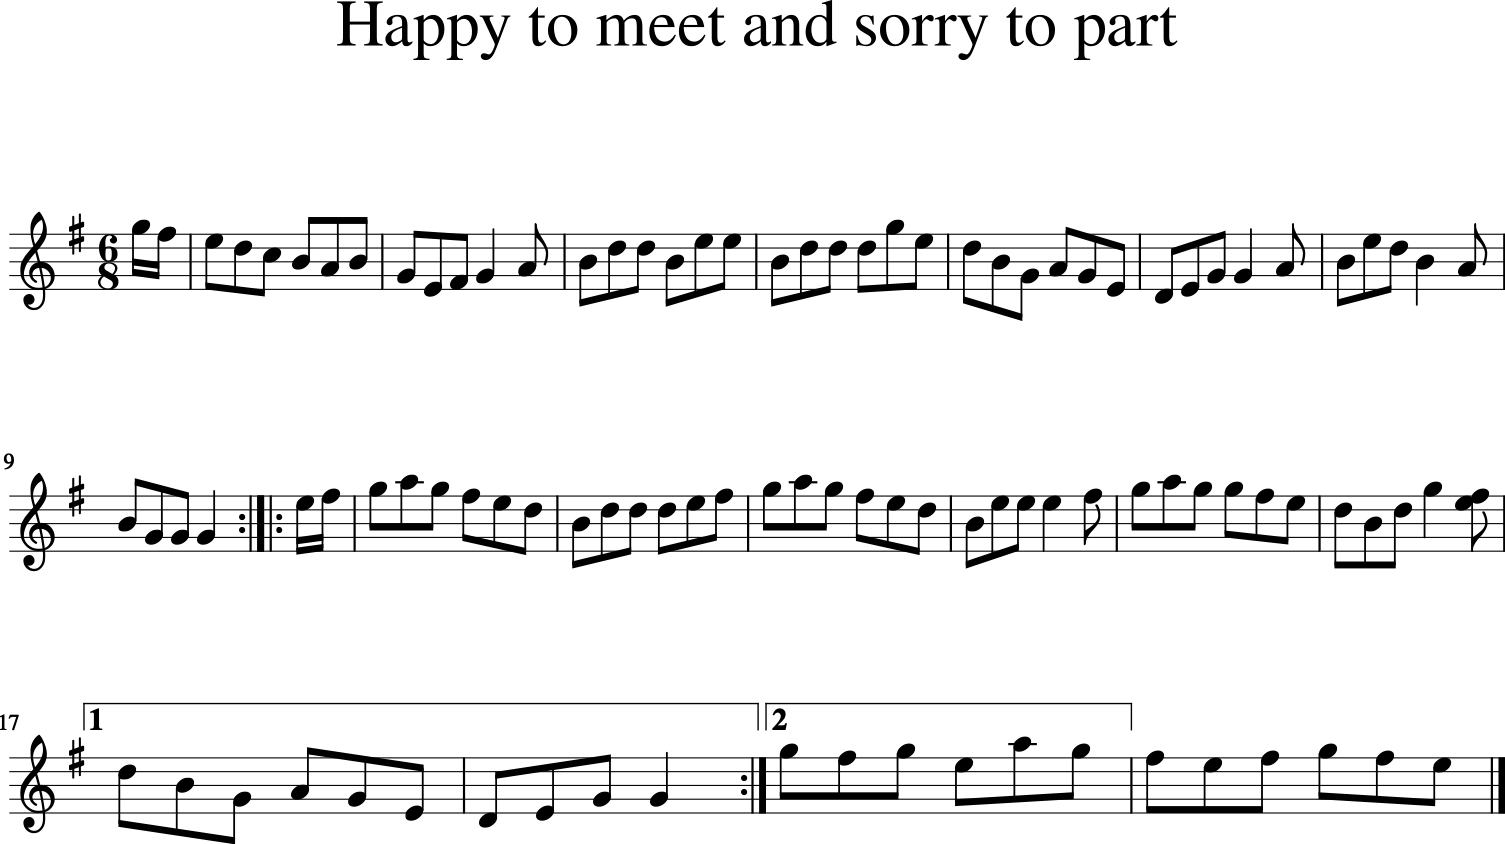





========== Exceptions contiaining '~' (19) ==========

reference number: 6
tune title: Doctor O'Neill
origin: Ireland
book: Francis O'Neill: "The Dance Music of Ireland" (1907) no. 6
rhythm: Double jig
transcription: Transcribed by Frank Nordberg - http://www.musicaviva.com
file url: http://www.musicaviva.com/abc/tunes/ireland/oneill-1001/oneill-1001-0006.abc
meter: 6/8
unit note length: 1/8
key: D
tune: A|~d3 AFD|E2F G2 A|BGB Bcd|AGF EFA|~d3 AFD| E2 F G2 A|BGB Bcd|AFD D2:|A|~d3 ceA|dfe dcB| AFA Bcd|AGF EFA|~d3 ceA|dfe dcB|AFA Bcd|AFD D2:|g| {g}fef afd|ded fed|gbg faf|gee e2 g| {g}fef afd|ded fed|gbg fag|fdd d2:|g| {g}fdf ece|{e}dcB AFA|AFd AFd|AGF E2 g|{g}fdf ece|dcB AFA| AFA Bcd|AFD D2::G|FAF GBG|FAG FED|FAF GBG|AGF E2G| FAF GBG|FAG FED|BGB Bcd|AFD D2:|




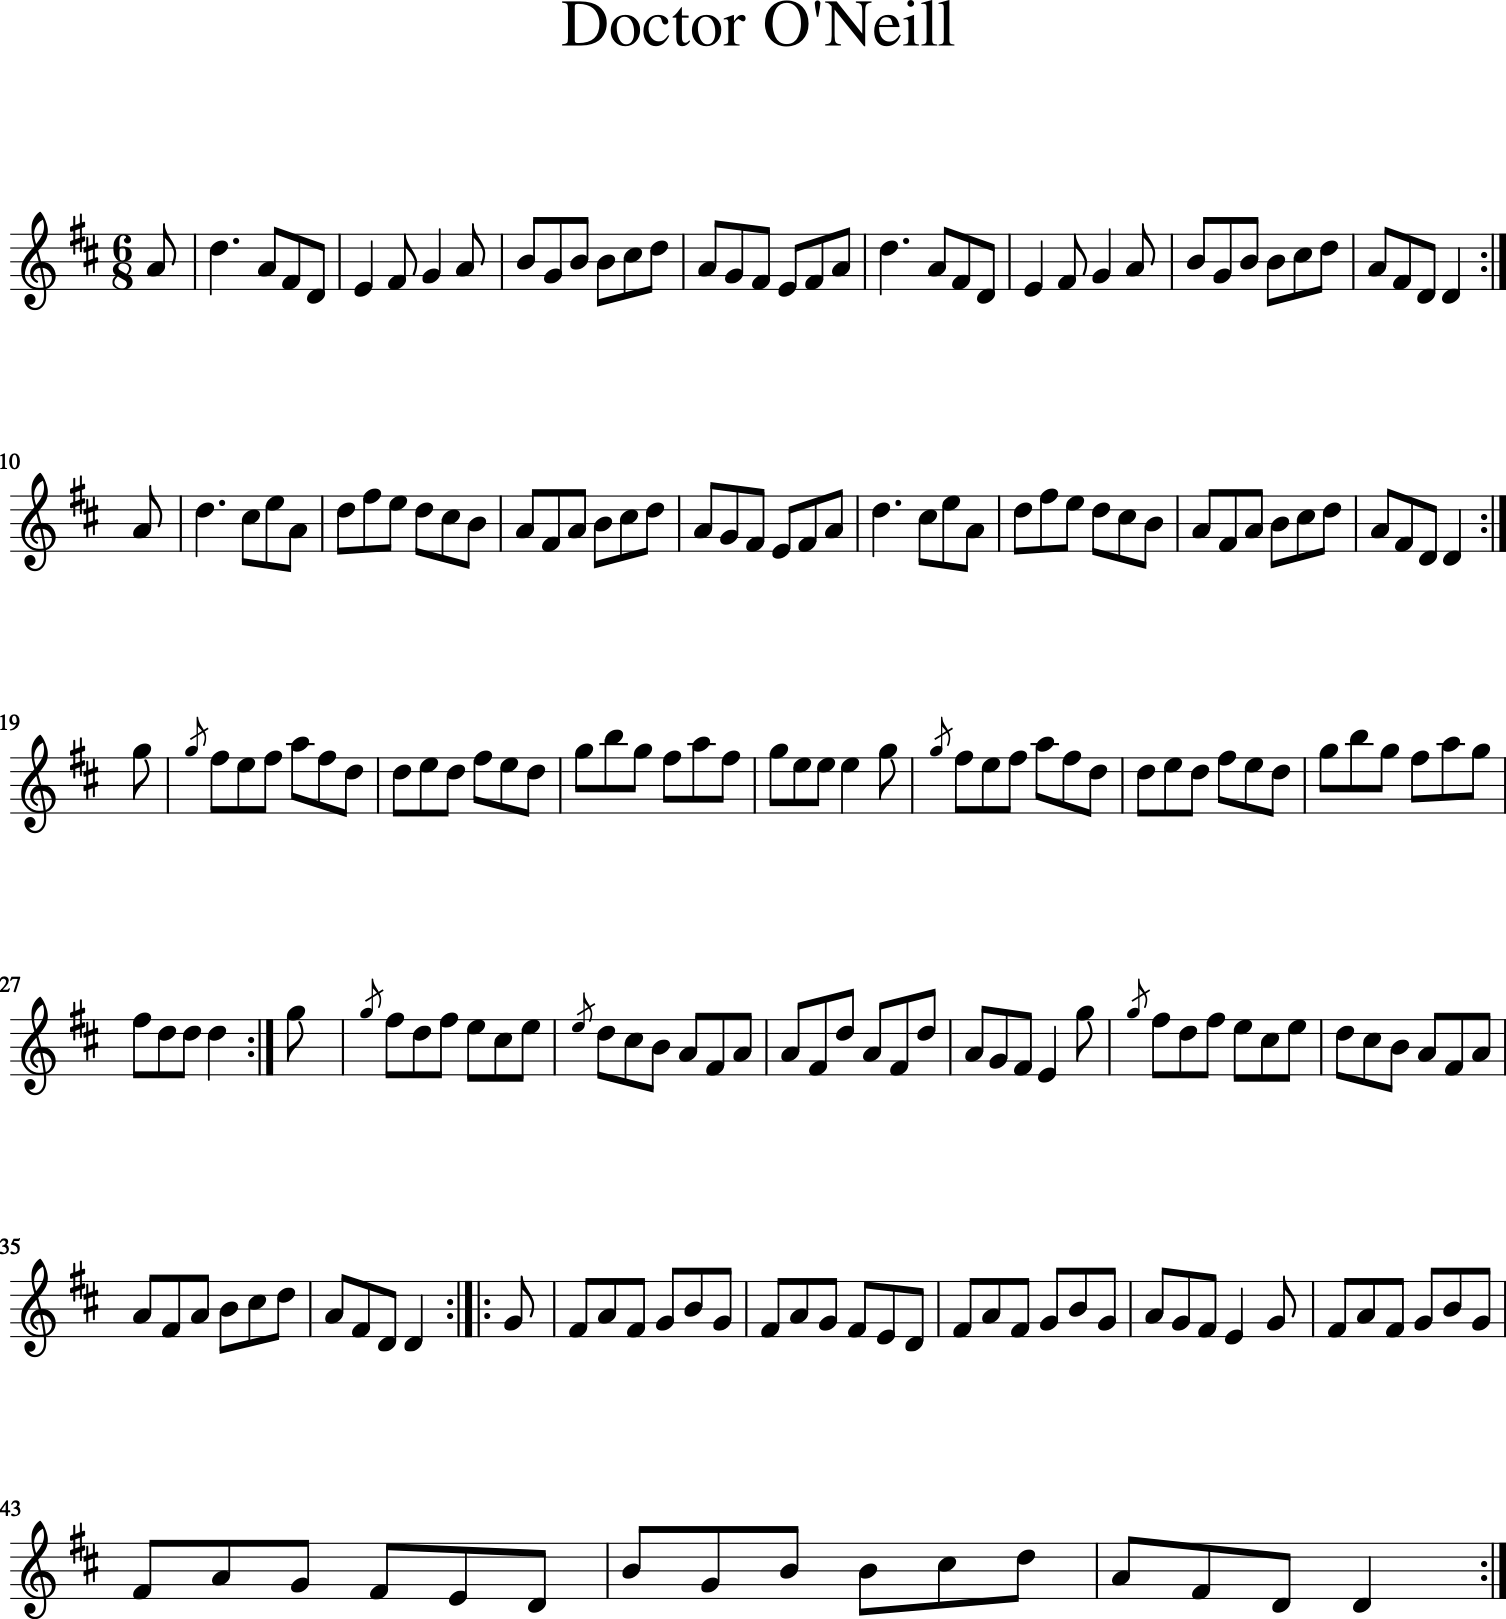




 ... 



========== Exceptions contiaining 'z' (21) ==========

reference number: 9
tune title: The pipe on the hob
origin: Ireland
book: Francis O'Neill: "The Dance Music of Ireland" (1907) no. 9
rhythm: Double jig
transcription: Transcribed by Frank Nordberg - http://www.musicaviva.com
file url: http://www.musicaviva.com/abc/tunes/ireland/oneill-1001/oneill-1001-0009.abc
meter: 6/8
unit note length: 1/8
key: Am
tune: B|c3 edc|edc BAG|ABA {a}g z e|eaa ged|~c3 edc|edc deg|age dBe|ABAA2:| ^f|g3 {a}gea|age edB| ABA {a}g z e|aba eg^f| g3 {a}gea|age e^fg|age dBe|ABA A2:| B|c2cd2d|ecA AGE|c2cd2d|ecA A2B|c2cd2d|e2e ^gab|a=ge dBe|ABAA2:|




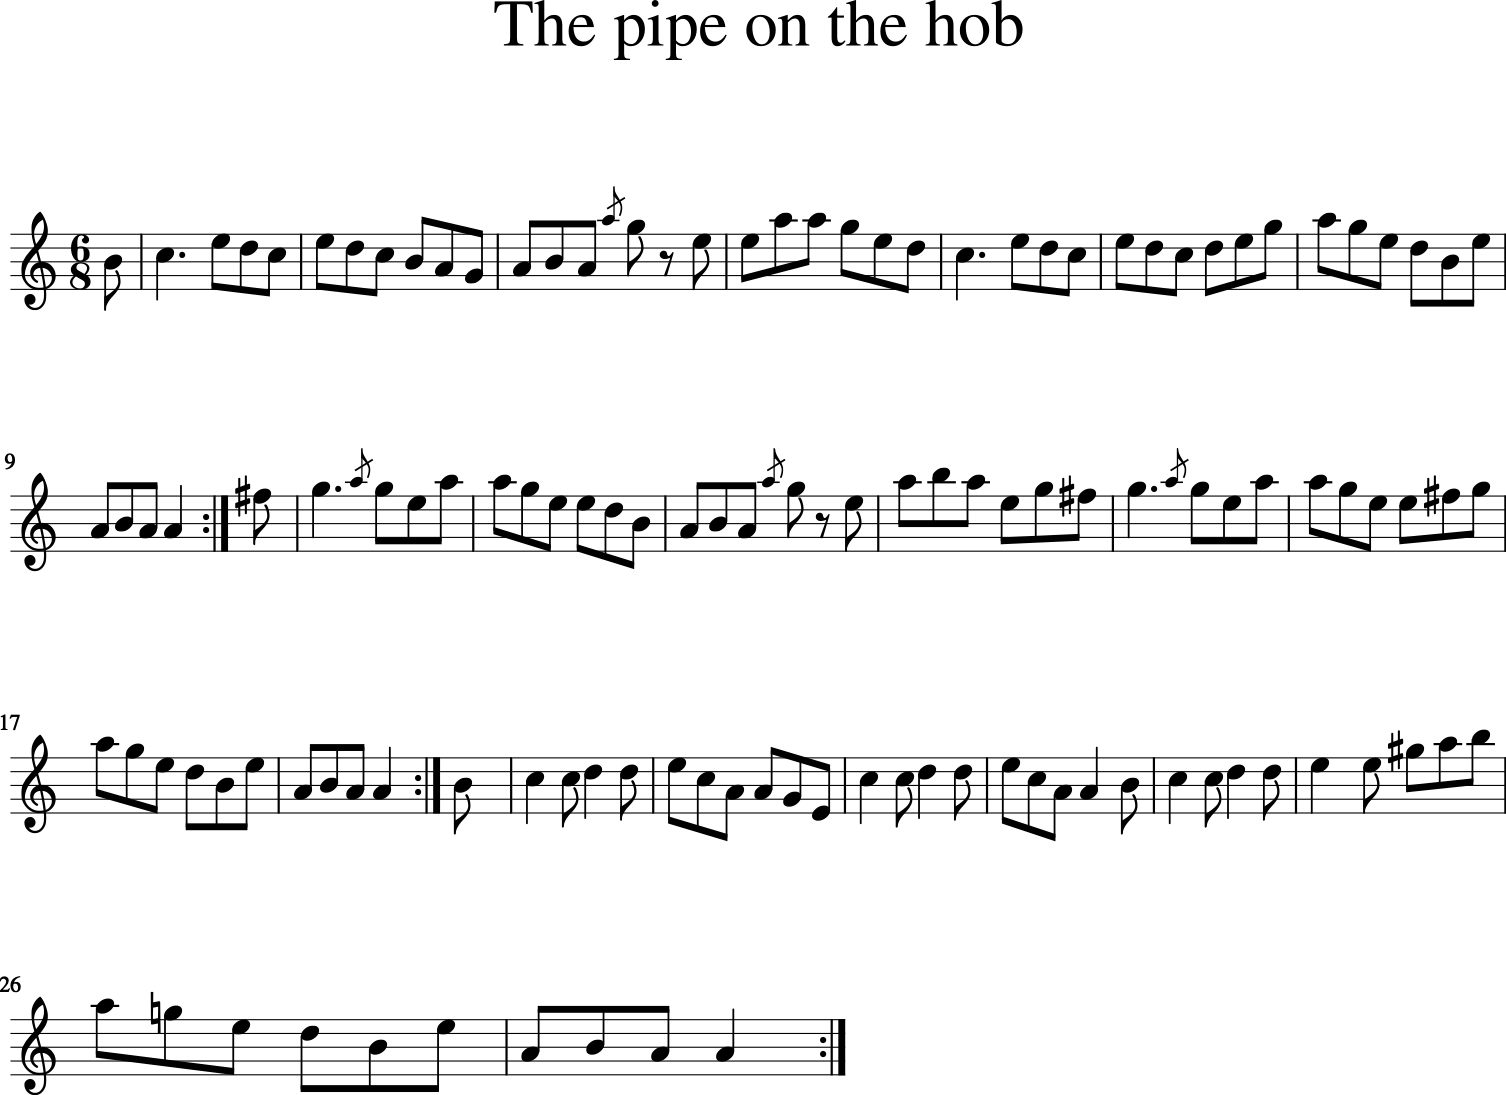




 ... 



========== Exceptions contiaining '{' (101) ==========

reference number: 2
tune title: The piper's picnic
origin: Ireland
book: Francis O'Neill: "The Dance Music of Ireland" (1907) no. 2
rhythm: Double jig
transcription: Transcribed by Frank Nordberg - http://www.musicaviva.com
file url: http://www.musicaviva.com/abc/tunes/ireland/oneill-1001/oneill-1001-0002.abc
meter: 6/8
unit note length: 1/8
key: A
tune: E|AcA BGE|cde dBG| AcA BGE|{F}EDE GAB|AcA BGE|cde dBG|{d}cBA BGE|EFG A2:| (A/B/)|ceA ceA|cee edc|(B/c/d)G (B/c/d)G|Bdd dcB| cde dcB|{d}cBA Ggf|ecA GED|EFGA2:|




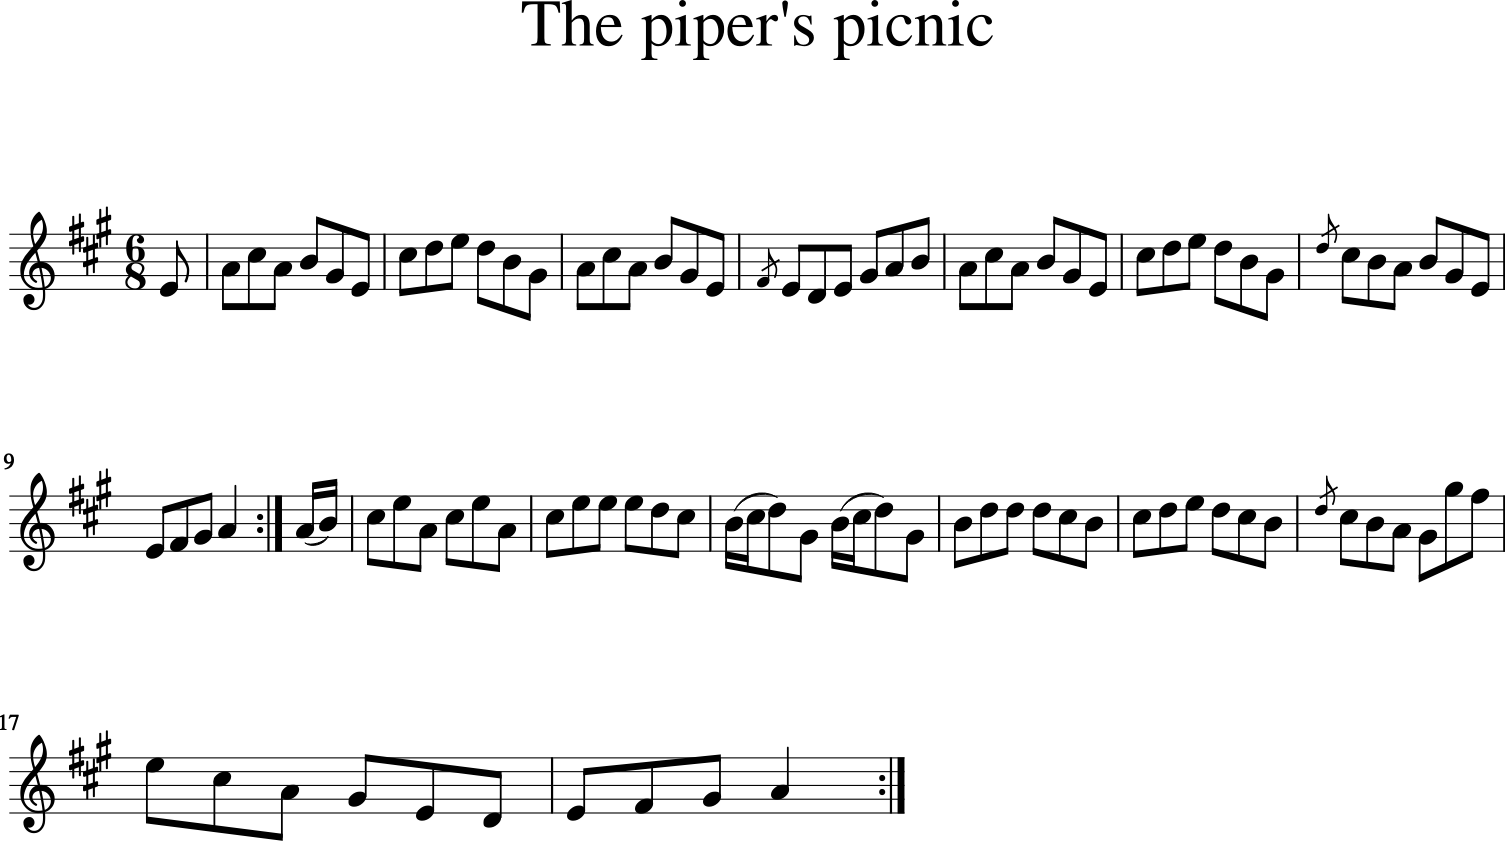




 ... 



========== Exceptions contiaining '"' (5) ==========

reference number: 78
tune title: Happy to meet and sorry to part
origin: Ireland
book: Francis O'Neill: "The Dance Music of Ireland" (1907) no. 78
rhythm: Double jig
transcription: Transcribed by Frank Nordberg - http://www.musicaviva.com
file url: http://www.musicaviva.com/abc/tunes/ireland/oneill-1001/oneill-1001-0078.abc
meter: 6/8
unit note length: 1/8
key: G
tune: g/f/S|edc BAB|GEF G2A|Bdd Bee|Bdd dge|dBG AGE|DEG G2A|Bed B2A|BGG G2:| |:e/f/|gag fed|Bdd def|gag fed|Bee e2f|gag gfe|dBd g2 "^2d""_1st"[ef]|[1 dBG AGE|DEG G2:|[2 gfg eag|fef gfeS|]




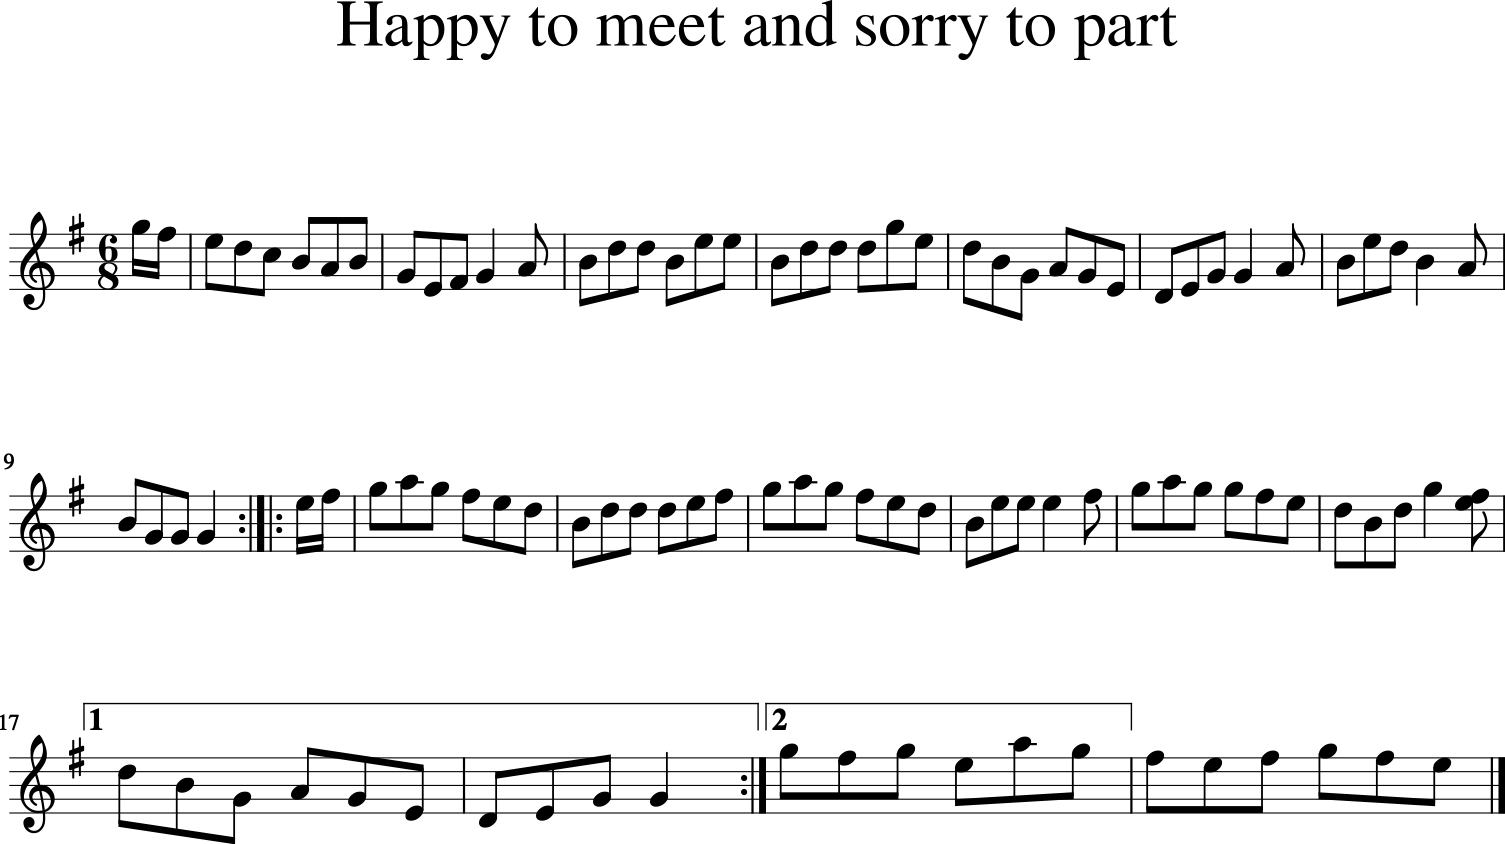




 ... 



In [35]:
for query, exceptions in weird_tunes.items():
    count = len(exceptions)
    print(f"\n\n{10*'='} Exceptions contiaining '{query}' ({count}) {10*'='}\n")
    max_print = 1
    for (idx, _) in exceptions[:max_print]:
        abc = parsed_abc[idx]
        for k, v in abc.items():
            print(f"{k}: {v}")
        print("\n")
#         oneills_opus.scores[idx].show()
        print("\n")
    if count > max_print:
        print("\n ... \n")
        
        

# Preprocessing ================================

Preprocessing to do:
* [x] Check L: is standard for all tunes
  * It's 1/8 for all tunes
* [x] Only keep M: and K:
* [x] Transpose all tunes to be centred at C
  * used FolkRNN-parser to tokenize, then rolled my own transposition code on tokens
  * tried to use music21 - no export to abc, only lilypond. then tried ly2abc.py, but this messed up bars
* [x] Remove all ornaments and gracenotes
  * appears to be done by `python FolkRNN-parser.py -f ../double-jig-gen/data/oneills_tunes -o oniells_double_jigs.abc`
* [x] Add `=` (indicating the note is natural i.e. not flat nor sharp) onto all notes which are natural
* [x] Separate into tokens
    * Hopefully can just use FolkRNN-parser.py
    * [x] Check that brackets are handled correctly, 
        * seems like you can open a bracket and not close it if it's finished by a bar

Example output:
```
M:9/8
K:maj
=G =E =E =E 2 =D =E =D =C | =G =E =E =E =F =G =A =B =c | =G =E =E =E 2 =D =E =D =C | =A =D =D =G =E =C =D 2 =A | =G =E =E =E 2 =D =E =D =C | =G =E =E =E =F =G =A =B =c | =G =E =E =E 2 =D =E =D =C | =A =D =D =G =E =C =D 2 =D | =E =D =E =c 2 =A =B =A =G | =E =D =E =A /2 =B /2 =c =A =B 2 =D | =E =D =E =c 2 =A =B =A =G | =A =D =D =D =E =G =A 2 =D | =E =D =E =c 2 =A =B =A =G | =E =D =E =A /2 =B /2 =c =A =B 2 =B | =G =A =B =c =B =A =B =A =G | =A =D =D =D =E =G =A =B =c |

```

## Remove the lydian tune

In [36]:
oneills_df = oneills_df.loc[oneills_df.key != 'Glyd', :]

## Transpose

In [37]:
oneills_df.key.value_counts()

G       129
D       112
Am       29
A        27
Em       20
Ador     12
Amix     10
Dmix      5
C         5
Ddor      3
Gm        3
Bm        2
F         2
Edor      2
Dm        2
Gdor      1
Name: key, dtype: int64

### Get nr_semitones to transpose

In [38]:
# This only works as there are no flat or sharp keys
num_letter = {
    0: "C",
    2: "D",
    4: "E",
    5: "F",
    7: "G",
    9: "A",
    10: "Bb",
    11: "B",
}
letter_num = {v: k for k, v in num_letter.items()}
mode_num = {
    'dor': -2,
    'mix': -7,
    'm': -9,
}
def transpose_key(key_str):
    letter = key_str[0]
    num = letter_num[letter]
    if len(key_str) > 1:
        mode = key_str[1:]
    else:
        mode = None
    if mode is not None:
        num = (num + mode_num[mode]) % 12
    diatonic_letter = num_letter[num]
    transpose_semitones = letter_num[diatonic_letter]
    if transpose_semitones > 6:
        transpose_semitones = transpose_semitones - 12
    return -transpose_semitones

In [39]:
oneills_df['transpose_semitones'] = oneills_df.key.apply(transpose_key)

In [40]:
oneills_df.groupby(['key', 'transpose_semitones']).size()

key   transpose_semitones
A      3                      27
Ador   5                      12
Am     0                      29
Amix  -2                      10
Bm    -2                       2
C      0                       5
D     -2                     112
Ddor   0                       3
Dm    -5                       2
Dmix   5                       5
Edor  -2                       2
Em     5                      20
F     -5                       2
G      5                     129
Gdor  -5                       1
Gm     2                       3
dtype: int64

### Can we use `music21` (& `ly2abc`) to write new abc?
Spoiler: no. The bar lines get messed up somewhere.
This code just checks the transpose semitones are correct.

In [41]:
oneills_df.loc[1]

reference number                                                       2
tune title                                            The piper's picnic
origin                                                           Ireland
book                   Francis O'Neill: "The Dance Music of Ireland" ...
rhythm                                                        Double jig
transcription          Transcribed by Frank Nordberg - http://www.mus...
file url               http://www.musicaviva.com/abc/tunes/ireland/on...
meter                                                                6/8
unit note length                                                     1/8
key                                                                    A
tune                   E|AcA BGE|cde dBG| AcA BGE|{F}EDE GAB|AcA BGE|...
words                                                                NaN
transpose_semitones                                                    3
Name: 1, dtype: object

In [42]:
oneills_df.loc[oneills_df.key.str.contains('mix')]

,reference number,tune title,origin,book,rhythm,transcription,file url,meter,unit note length,key,tune,words,transpose_semitones
14,15,The highway to Dublin,Ireland,"Francis O'Neill: ""The Dance Music of Ireland"" ...",Double jig,Transcribed by Frank Nordberg - http://www.mus...,http://www.musicaviva.com/abc/tunes/ireland/on...,6/8,1/8,Amix,g|fed cBA|ecA A2g|fed cBc|dBG G2g|f>ed c>BA|de...,NaN,-2
17,18,Saddle the pony,Ireland,"Francis O'Neill: ""The Dance Music of Ireland"" ...",Double jig,Transcribed by Frank Nordberg - http://www.mus...,http://www.musicaviva.com/abc/tunes/ireland/on...,6/8,1/8,Amix,g|:fed cAA|eAA cBA|fed cAA|BGB dBG|fed cAA|cAA...,NaN,-2
48,49,The hare in the corn,Ireland,"Francis O'Neill: ""The Dance Music of Ireland"" ...",Double jig,Transcribed by Frank Nordberg - http://www.mus...,http://www.musicaviva.com/abc/tunes/ireland/on...,6/8,1/8,Dmix,B|BAB c2A|BAB c2A|BdB AFD|EFE E2c|BAB c2A|BAB ...,NaN,5
61,62,Fiddler's heaven,Ireland,"Francis O'Neill: ""The Dance Music of Ireland"" ...",Double jig,Transcribed by Frank Nordberg - http://www.mus...,http://www.musicaviva.com/abc/tunes/ireland/on...,6/8,1/8,Amix,B/c/|dAF FEF|ded dfe|dAF FEF|AFE EFA|dAF FEF|d...,NaN,-2
65,66,The humors of Tralibane,Ireland,"Francis O'Neill: ""The Dance Music of Ireland"" ...",Double jig,Transcribed by Frank Nordberg - http://www.mus...,http://www.musicaviva.com/abc/tunes/ireland/on...,6/8,1/8,Amix,g/f/|ecA Ace|dBG GBd|cBA ecA|def {a}gfg|ecA Ac...,NaN,-2
66,67,Connie the soldier,Ireland,"Francis O'Neill: ""The Dance Music of Ireland"" ...",Double jig,Transcribed by Frank Nordberg - http://www.mus...,http://www.musicaviva.com/abc/tunes/ireland/on...,6/8,1/8,Dmix,A/G/|EAA A2d|cAG E2D|DGG DEE|DGG GED|EAA A2d|c...,NaN,5
73,74,A trip to the cottage,Ireland,"Francis O'Neill: ""The Dance Music of Ireland"" ...",Double jig,Transcribed by Frank Nordberg - http://www.mus...,http://www.musicaviva.com/abc/tunes/ireland/on...,6/8,1/8,Dmix,B/c/|dcd BGB|cBc AFA|DGG FAA|GBB ABc|dcd BGB|c...,NaN,5
116,117,The highlander,Ireland,"Francis O'Neill: ""The Dance Music of Ireland"" ...",Double jig,Transcribed by Frank Nordberg - http://www.mus...,http://www.musicaviva.com/abc/tunes/ireland/on...,6/8,1/8,Amix,(g/f/)S|e2A ABA|e2A Bcd|e2A ABA|dBG Bcd|e2A g2...,W: --- W:1) Org. not dotted.,-2
136,137,The victor's return,Ireland,"Francis O'Neill: ""The Dance Music of Ireland"" ...",Double jig,Transcribed by Frank Nordberg - http://www.mus...,http://www.musicaviva.com/abc/tunes/ireland/on...,6/8,1/8,Amix,(g/f/)|eAA fed|eAAf2d|eAA gfe|dBG Bgf|eAA fed|...,NaN,-2
141,142,The jolly old man,Ireland,"Francis O'Neill: ""The Dance Music of Ireland"" ...",Double jig,Transcribed by Frank Nordberg - http://www.mus...,http://www.musicaviva.com/abc/tunes/ireland/on...,6/8,1/8,Amix,E|AGA c2d|edc BcA|GFG B2c|dge dBG|AGA c2d|edc ...,NaN,-2


In [43]:
oneills_df.loc[14]

reference number                                                      15
tune title                                         The highway to Dublin
origin                                                           Ireland
book                   Francis O'Neill: "The Dance Music of Ireland" ...
rhythm                                                        Double jig
transcription          Transcribed by Frank Nordberg - http://www.mus...
file url               http://www.musicaviva.com/abc/tunes/ireland/on...
meter                                                                6/8
unit note length                                                     1/8
key                                                                 Amix
tune                   g|fed cBA|ecA A2g|fed cBc|dBG G2g|f>ed c>BA|de...
words                                                                NaN
transpose_semitones                                                   -2
Name: 14, dtype: object

In [44]:
score = oneills_opus.scores[14]

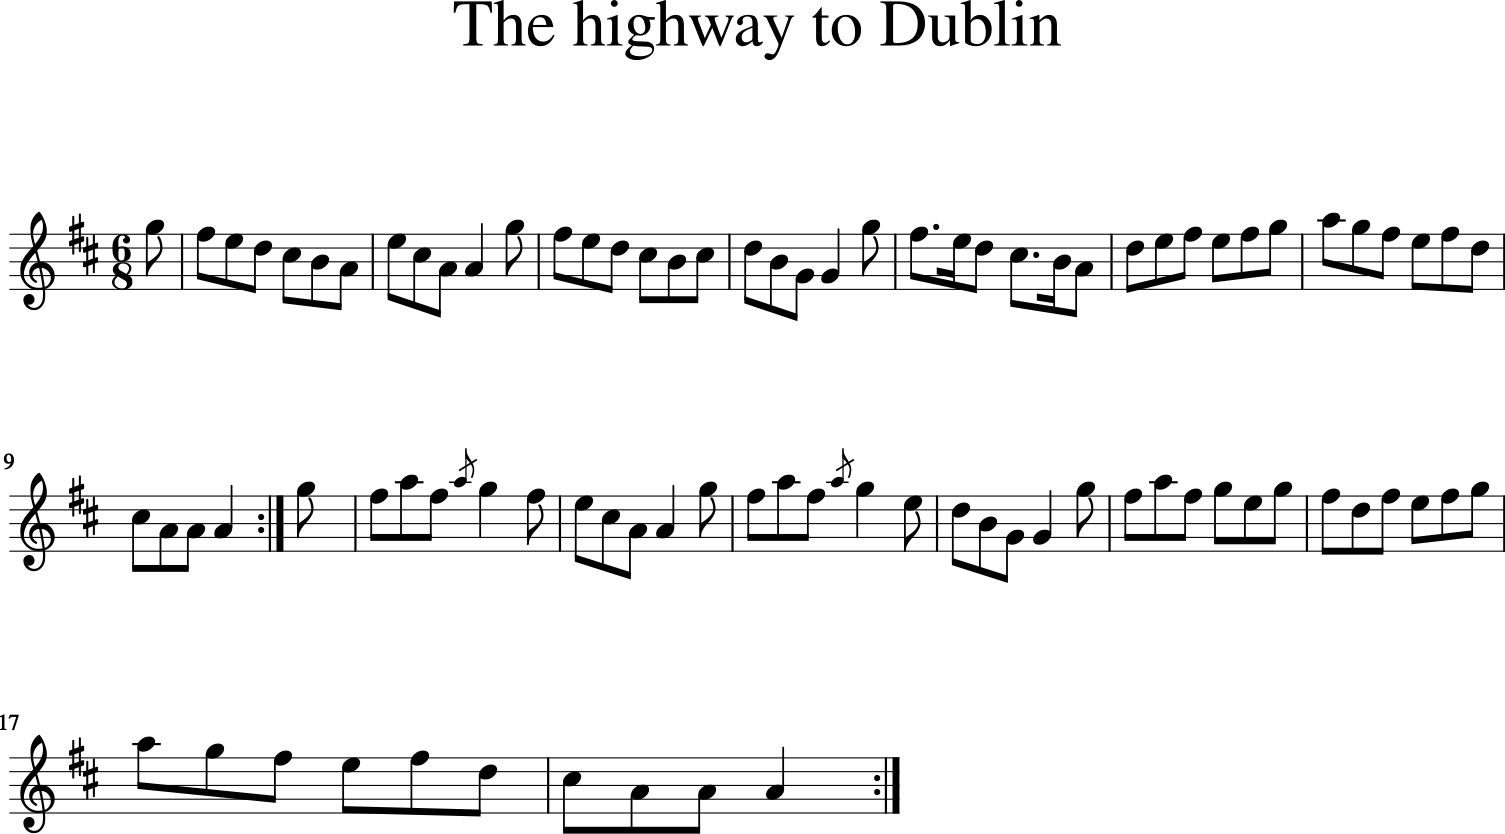

In [45]:
score.show()

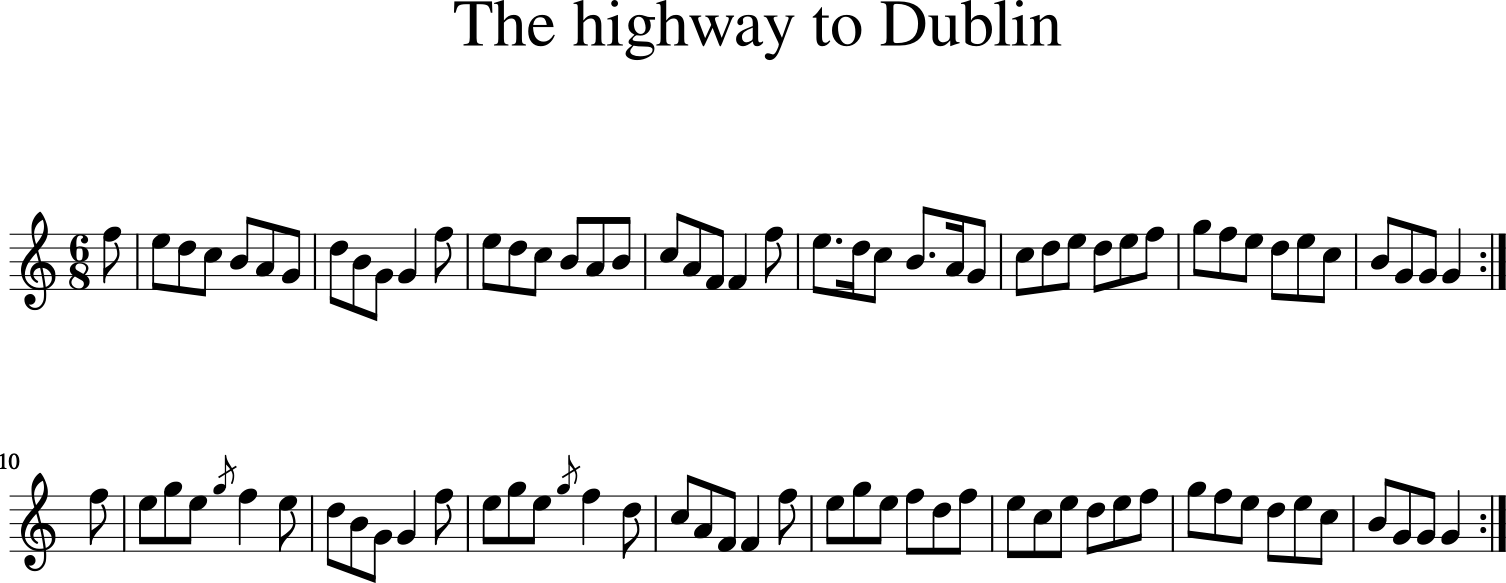

In [46]:
s2 = score.transpose(oneills_df.loc[14, 'transpose_semitones'])
s2.show()

In [47]:
oneills_df.loc[oneills_df.key.str.endswith('m')]

,reference number,tune title,origin,book,rhythm,transcription,file url,meter,unit note length,key,tune,words,transpose_semitones
8,9,The pipe on the hob,Ireland,"Francis O'Neill: ""The Dance Music of Ireland"" ...",Double jig,Transcribed by Frank Nordberg - http://www.mus...,http://www.musicaviva.com/abc/tunes/ireland/on...,6/8,1/8,Am,B|c3 edc|edc BAG|ABA {a}g z e|eaa ged|~c3 edc|...,NaN,0
13,14,Off to the hunt,Ireland,"Francis O'Neill: ""The Dance Music of Ireland"" ...",Double jig,Transcribed by Frank Nordberg - http://www.mus...,http://www.musicaviva.com/abc/tunes/ireland/on...,6/8,1/8,Am,E|ABA ABd|ege dBG|G^FG BAG|dBG BAG|A>BA ABd|e^...,NaN,0
27,28,Contentment is wealth,Ireland,"Francis O'Neill: ""The Dance Music of Ireland"" ...",Double jig,Transcribed by Frank Nordberg - http://www.mus...,http://www.musicaviva.com/abc/tunes/ireland/on...,6/8,1/8,Am,(A/B/)|c>BA (A<a)g|e>^de A2c|B>AG Gge|d>(cB/A/...,NaN,0
31,32,The basket of Turf,Ireland,"Francis O'Neill: ""The Dance Music of Ireland"" ...",Double jig,Transcribed by Frank Nordberg - http://www.mus...,http://www.musicaviva.com/abc/tunes/ireland/on...,6/8,1/8,Em,E|EBB BAG|FDF AGF|EBB Bcd|AGF E2E|EGB BAG|FDF ...,NaN,5
33,34,Galway Tom,Ireland,"Francis O'Neill: ""The Dance Music of Ireland"" ...",Double jig,Transcribed by Frank Nordberg - http://www.mus...,http://www.musicaviva.com/abc/tunes/ireland/on...,6/8,1/8,Bm,def fef|fef fef|def fef|edB BAB|def fef|fef fe...,NaN,-2
34,35,Money in both pockets,Ireland,"Francis O'Neill: ""The Dance Music of Ireland"" ...",Double jig,Transcribed by Frank Nordberg - http://www.mus...,http://www.musicaviva.com/abc/tunes/ireland/on...,6/8,1/8,Am,G|c2E EDE|GAG GFE|c2E EDE|G2g fed|c2E EDE|GAG ...,NaN,0
40,41,The templehouse jig,Ireland,"Francis O'Neill: ""The Dance Music of Ireland"" ...",Double jig,Transcribed by Frank Nordberg - http://www.mus...,http://www.musicaviva.com/abc/tunes/ireland/on...,6/8,1/8,Em,D|(EF)E G2(A|B)AB G2E|DED FEF|(A/B/d)(B A)FD| ...,NaN,5
44,45,Out with the boys,Ireland,"Francis O'Neill: ""The Dance Music of Ireland"" ...",Double jig,Transcribed by Frank Nordberg - http://www.mus...,http://www.musicaviva.com/abc/tunes/ireland/on...,6/8,1/8,Em,(3D/E/F/|G3 g2e|dBG AGE|DEG BAG|BAA (A2B/A/)|G...,NaN,5
47,48,The miller of Glanmire,Ireland,"Francis O'Neill: ""The Dance Music of Ireland"" ...",Double jig,Transcribed by Frank Nordberg - http://www.mus...,http://www.musicaviva.com/abc/tunes/ireland/on...,6/8,1/8,Am,G|EAA EAA|~B3 G2A|Bee edB|de^f gag|eaa age|dBG...,NaN,0
63,64,Darby the driver,Ireland,"Francis O'Neill: ""The Dance Music of Ireland"" ...",Double jig,Transcribed by Frank Nordberg - http://www.mus...,http://www.musicaviva.com/abc/tunes/ireland/on...,6/8,1/8,Am,A/G/|EAA ABc|BAA A2 (B/c/)|d2e dBg|BGG G2 (A/G...,NaN,0


In [48]:
oneills_df.loc[31]

reference number                                                      32
tune title                                            The basket of Turf
origin                                                           Ireland
book                   Francis O'Neill: "The Dance Music of Ireland" ...
rhythm                                                        Double jig
transcription          Transcribed by Frank Nordberg - http://www.mus...
file url               http://www.musicaviva.com/abc/tunes/ireland/on...
meter                                                                6/8
unit note length                                                     1/8
key                                                                   Em
tune                   E|EBB BAG|FDF AGF|EBB Bcd|AGF E2E|EGB BAG|FDF ...
words                                                                NaN
transpose_semitones                                                    5
Name: 31, dtype: object

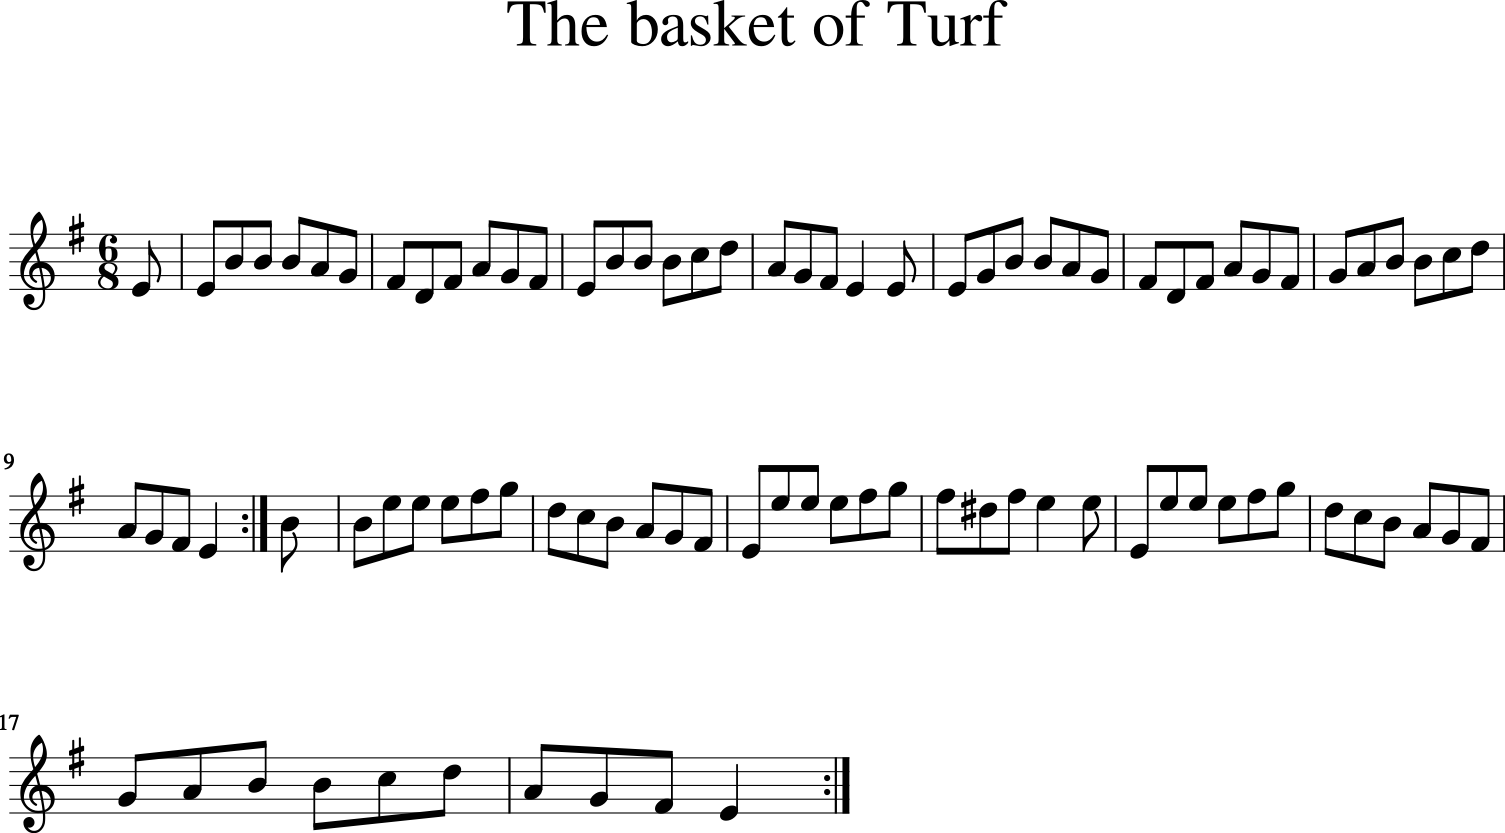

In [49]:
score = oneills_opus.scores[31]
score.show()

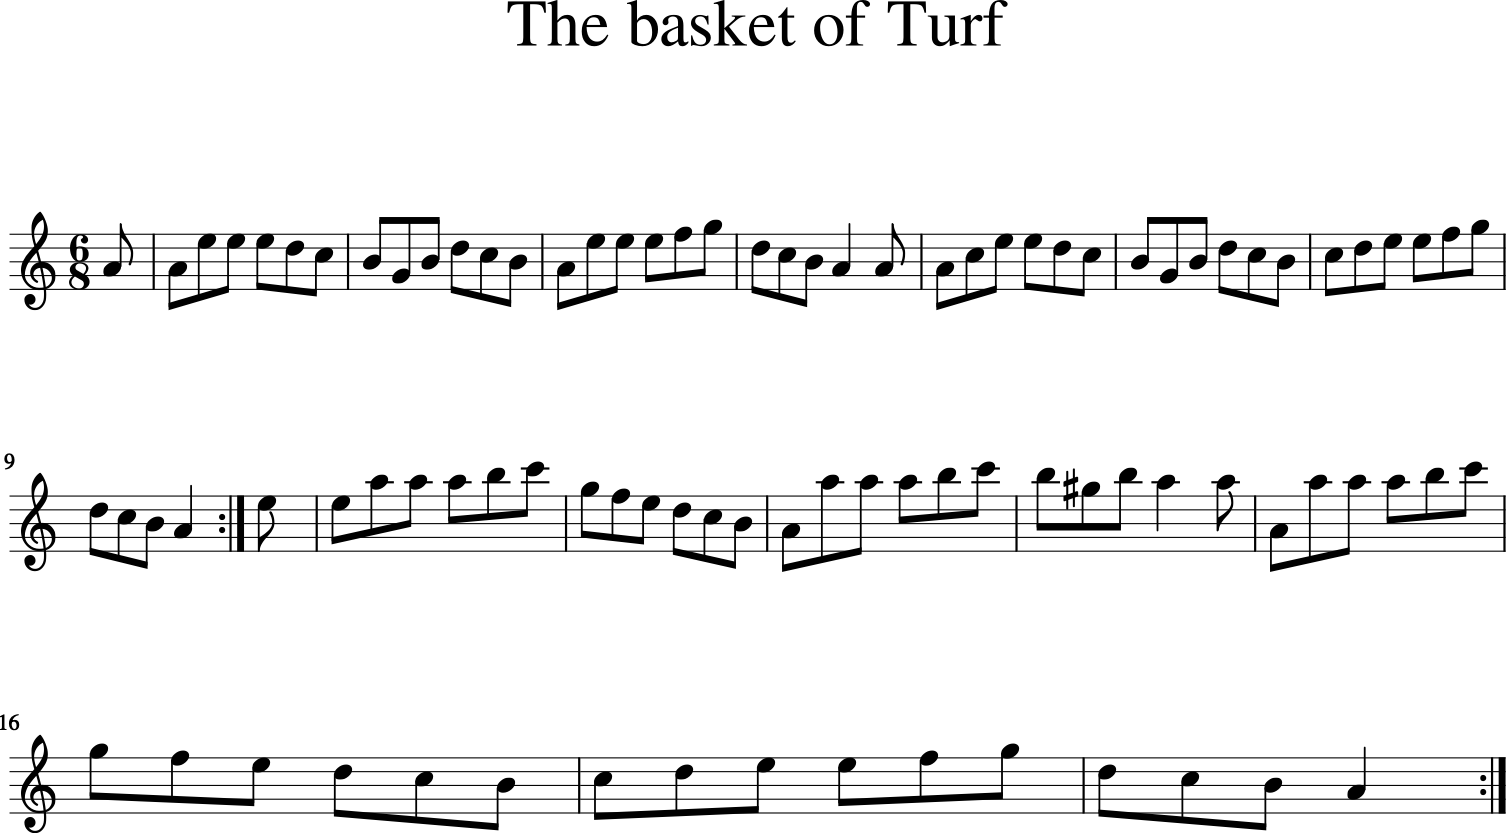

In [50]:
s2 = score.transpose(oneills_df.loc[31, 'transpose_semitones'])
s2.show()

In [51]:
def make_transposed_music21(row):
    ref_idx = int(row["reference number"])
    trans_semitones = row["transpose_semitones"]
    score = oneills_opus.scores[ref_idx - 1].transpose(trans_semitones)
    return score

In [52]:
oneills_df["transposed_music21"] = oneills_df.apply(make_transposed_music21, axis=1)

In [53]:
output_dir = Path(data_path, "oneills_lilypond")
output_dir.mkdir(parents=True, exist_ok=True)
for idx, row in oneills_df.iterrows():
    tune_ref = row['reference number']
    outpath = Path(output_dir, f"tune_{int(tune_ref):03d}.lp")
    row["transposed_music21"].write(fmt='lilypond', fp=str(outpath))

In [54]:
output_dir = Path(data_path, "oneills_transposed")
output_dir.mkdir(parents=True, exist_ok=True)

```bash
for filepath in ../double-jig-gen/data/oneills_lilypond/*; do
    filename="${filepath##*/}"
    filename="${filename%.*}"
    outpath="../double-jig-gen/data/oneills_transposed/${filename}.abc"
    echo "Processing $filename"
    pipenv run python ly2abc.py $filepath > $outpath
done
```

In [55]:
tok_data_path = Path(data_path, "folkrnn_parser_output", "oneills_transposed.abc")
with open(str(tok_data_path), "r") as fh:
    tok_data = fh.read().strip()
tok_tunes = [
    tune_str.split('\n')[3][len("[M:6/8] [L:1/8] "):]
    for tune_str in tok_data.split('\n\n')
]
tok_tunes[1]

'G | c e c d B | G | e f g f d | B | c e c d B | G | G F G B c | d | c e c d B | G | e f g f d | B | e d c d B | G | G A B c 2 | c /2 d /2 | e g c e g | c | e g g g f | e | d /2 e /2 f B d /2 e /2 f | B | d f f f e | d | e f g f e | d | e d c B b | a | g e c B G | F | G A B c 2 |'

DAMMIT!!! THE BARS ARE ALL MESSED UP...

In [56]:
len(tok_tunes)

364

## Tokenize and clean with `FolkRNN-parser`

### Write individual files out

In [57]:
oneills_df.dtypes

reference number       object
tune title             object
origin                 object
book                   object
rhythm                 object
transcription          object
file url               object
meter                  object
unit note length       object
key                    object
tune                   object
words                  object
transpose_semitones     int64
transposed_music21     object
dtype: object

In [58]:
output_dir = Path(data_path, "oneills_tunes")
for idx, row in oneills_df.iterrows():
    with open(str(Path(output_dir, f"tune_{int(row['reference number']):03d}.abc")), "w") as fh:
        tune_str = f"M:{row.meter}\nK:{row.key}\n{row.tune}"
        fh.write(tune_str)


NB I edited the FolkRNN-parser code to sort the files such that they stay in order

```bash
python ../../polska/FolkRNN-parser.py -f ../data/oneills_tunes -o ../data/folkrnn_parser_output/oneills_transposed.abc 
```

### Read back

In [59]:
tok_data_path = Path(data_path, "folkrnn_parser_output", "oneills_double_jigs.abc")
with open(str(tok_data_path), "r") as fh:
    tok_data = fh.read().strip()
tok_tunes = [tune_str.split('\n')[-1].split() for tune_str in tok_data.split('\n\n')]

In [60]:
len(tok_tunes)

364

In [61]:
oneills_df["tune_str"] = oneills_df["tune"]

In [62]:
oneills_df["tune"] = tok_tunes

In [63]:
oneills_df

,reference number,tune title,origin,book,rhythm,transcription,file url,meter,unit note length,key,tune,words,transpose_semitones,transposed_music21,tune_str
0,1,Shandon bells,Ireland,"Francis O'Neill: ""The Dance Music of Ireland"" ...",Double jig,Transcribed by Frank Nordberg - http://www.mus...,http://www.musicaviva.com/abc/tunes/ireland/on...,6/8,1/8,D,"[B, |:, A, F, D, D, F, A, |, d, e, d, c, B, A,...",NaN,-2,[<music21.metadata.Metadata object at 0x7fa313...,B|:AFD DFA|ded cBA|BGE EFA|B2A Bcd| AFD DFA|de...
1,2,The piper's picnic,Ireland,"Francis O'Neill: ""The Dance Music of Ireland"" ...",Double jig,Transcribed by Frank Nordberg - http://www.mus...,http://www.musicaviva.com/abc/tunes/ireland/on...,6/8,1/8,A,"[E, |, A, c, A, B, G, E, |, c, d, e, d, B, G, ...",NaN,3,[<music21.metadata.Metadata object at 0x7fa324...,E|AcA BGE|cde dBG| AcA BGE|{F}EDE GAB|AcA BGE|...
2,3,Hartigan's fancy,Ireland,"Francis O'Neill: ""The Dance Music of Ireland"" ...",Double jig,Transcribed by Frank Nordberg - http://www.mus...,http://www.musicaviva.com/abc/tunes/ireland/on...,6/8,1/8,G,"[D, |, B, 2, B, G, B, d, |, c, B, c, A, B, c, ...",NaN,5,[<music21.metadata.Metadata object at 0x7fa2d2...,D|B2B GBd|cBc ABc|B2B GBd| cAG FGA|B2B GBd|cBc...
3,4,The yellow flail,Ireland,"Francis O'Neill: ""The Dance Music of Ireland"" ...",Double jig,Transcribed by Frank Nordberg - http://www.mus...,http://www.musicaviva.com/abc/tunes/ireland/on...,6/8,1/8,G,"[d, /2, c, /2, |, B, A, G, G, F, G, |, D, 2, E...",NaN,5,[<music21.metadata.Metadata object at 0x7fa2d3...,d/c/|BAG GFG|D2E ({G}F)EF|GAG GAB| {d}cAG FGA|...
4,5,Kitty's rambles,Ireland,"Francis O'Neill: ""The Dance Music of Ireland"" ...",Double jig,Transcribed by Frank Nordberg - http://www.mus...,http://www.musicaviva.com/abc/tunes/ireland/on...,6/8,1/8,D,"[G, |, F, E, D, =c, B, A, |, d, c, d, e, f, g,...",NaN,-2,[<music21.metadata.Metadata object at 0x7fa324...,G|FED ({d}=c)BA|dcd efg|fed ({d}=c)AF|GAF GFE|...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,361,The Drogheda weavers,Ireland,"Francis O'Neill: ""The Dance Music of Ireland"" ...",Double jig,Transcribed by Frank Nordberg - http://www.mus...,http://www.musicaviva.com/abc/tunes/ireland/on...,6/8,1/8,D,"[A, F, D, D, F, D, |, A, F, D, G, 2, E, |, A, ...",W: --- W:Bar 8 last note org. 4th note,-2,[<music21.metadata.Metadata object at 0x7fa314...,AFD DFD|AFD (G2E)|AFD DF(G|A)FD TE2d|AFD DFD|A...
361,362,The Hollyford jig,Ireland,"Francis O'Neill: ""The Dance Music of Ireland"" ...",Double jig,Transcribed by Frank Nordberg - http://www.mus...,http://www.musicaviva.com/abc/tunes/ireland/on...,6/8,1/8,D,"[F, 3, A, G, F, |, A, B, A, G, E, D, |, E, G, ...",NaN,-2,[<music21.metadata.Metadata object at 0x7fa327...,TF3 AG(F|A)BA (GE)D|EGE (Tc2A)|(d/e/f)(d c)AG|...
362,363,Nell Kennedy,Ireland,"Francis O'Neill: ""The Dance Music of Ireland"" ...",Double jig,Transcribed by Frank Nordberg - http://www.mus...,http://www.musicaviva.com/abc/tunes/ireland/on...,6/8,1/8,G,"[A, |, B, 2, G, A, 2, F, |, G, F, D, F, G, A, ...",NaN,5,[<music21.metadata.Metadata object at 0x7fa2d4...,A|(B2G) (A2F)|GFD FGA|BAG (A2F)|G2(g f)dc|(B2G...
363,364,Three halfpence a day,Ireland,"Francis O'Neill: ""The Dance Music of Ireland"" ...",Double jig,Transcribed by Frank Nordberg - http://www.mus...,http://www.musicaviva.com/abc/tunes/ireland/on...,6/8,1/8,Ador,"[B, |, c, B, A, B, A, G, |, A, G, E, G, E, D, ...",NaN,5,[<music21.metadata.Metadata object at 0x7fa2d4...,B|cBA BA(G|A)GE (GE)D|cBA dB(G|E)AA A2B|cBA BA...


## Manual transpose

In [64]:
def transpose_tune(token_list, nr_semitones):
    new_token_list = []
    for tok in token_list:
        if ABC_PATTERN.match(tok):
            midipitch = abc_to_midipitch(tok)
            midipitch += nr_semitones
            tok = midipitch_to_abc(midipitch)
            new_token_list.append(tok)
        else:
            new_token_list.append(tok)
    return new_token_list

In [65]:
idx = 1
tune = oneills_df.loc[idx, "tune"]
nr_semitones = oneills_df.loc[idx, "transpose_semitones"]
oneills_df.loc[idx]

reference number                                                       2
tune title                                            The piper's picnic
origin                                                           Ireland
book                   Francis O'Neill: "The Dance Music of Ireland" ...
rhythm                                                        Double jig
transcription          Transcribed by Frank Nordberg - http://www.mus...
file url               http://www.musicaviva.com/abc/tunes/ireland/on...
meter                                                                6/8
unit note length                                                     1/8
key                                                                    A
tune                   [E, |, A, c, A, B, G, E, |, c, d, e, d, B, G, ...
words                                                                NaN
transpose_semitones                                                    3
transposed_music21     [<music21.metadata.Metadata 

In [66]:
transposed_tune = transpose_tune(tune, nr_semitones)

In [67]:
' '.join(tune)

'E | A c A B G E | c d e d B G | A c A B G E | E D E G A B | A c A B G E | c d e d B G | c B A B G E | E F G A 2 :| A /2 B /2 | c e A c e A | c e e e d c | B /2 c /2 d G B /2 c /2 d G | B d d d c B | c d e d c B | c B A G g f | e c A G E D | E F G A 2 :|'

In [68]:
' '.join(transposed_tune)

'G | c ^d c d ^A G | ^d f g f d ^A | c ^d c d ^A G | G F G ^A c d | c ^d c d ^A G | ^d f g f d ^A | ^d d c d ^A G | G ^G ^A c 2 :| c /2 d /2 | ^d g c ^d g c | ^d g g g f ^d | d /2 ^d /2 f ^A d /2 ^d /2 f ^A | d f f f ^d d | ^d f g f ^d d | ^d d c ^A ^a ^g | g ^d c ^A G F | G ^G ^A c 2 :|'

In [69]:
def trans_row(row):
    tune = row["tune"]
    oneills_df["transpose_semitones"]
    return transpose_tune(tune, nr_semitones)

In [73]:
oneills_df["trans_tune"] = oneills_df.apply(trans_row, axis=1)

In [76]:
oneills_df.head(2)

,reference number,tune title,origin,book,rhythm,transcription,file url,meter,unit note length,key,tune,words,transpose_semitones,transposed_music21,tune_str,trans_tune
0,1,Shandon bells,Ireland,"Francis O'Neill: ""The Dance Music of Ireland"" ...",Double jig,Transcribed by Frank Nordberg - http://www.mus...,http://www.musicaviva.com/abc/tunes/ireland/on...,6/8,1/8,D,"[B, |:, A, F, D, D, F, A, |, d, e, d, c, B, A,...",NaN,-2,[<music21.metadata.Metadata object at 0x7fa313...,B|:AFD DFA|ded cBA|BGE EFA|B2A Bcd| AFD DFA|de...,"[d, |:, c, ^G, F, F, ^G, c, |, f, g, f, ^d, d,..."
1,2,The piper's picnic,Ireland,"Francis O'Neill: ""The Dance Music of Ireland"" ...",Double jig,Transcribed by Frank Nordberg - http://www.mus...,http://www.musicaviva.com/abc/tunes/ireland/on...,6/8,1/8,A,"[E, |, A, c, A, B, G, E, |, c, d, e, d, B, G, ...",NaN,3,[<music21.metadata.Metadata object at 0x7fa324...,E|AcA BGE|cde dBG| AcA BGE|{F}EDE GAB|AcA BGE|...,"[G, |, c, ^d, c, d, ^A, G, |, ^d, f, g, f, d, ..."


## Add `=` to naturals

In [98]:
def add_equals_to_naturals(token_list):
    return [f"={tok}" if re.match(r"^[A-Ga-g]$", tok[0]) else tok for tok in token_list]

In [100]:
add_equals_to_naturals(["c", "^G"])

['=c', '^G']

In [101]:
idx = 0
tune = oneills_df.loc[idx, "trans_tune"]

In [103]:
' '.join(tune)

"d |: c ^G F F ^G c | f g f ^d d c | d ^A G G ^G c | d 2 c d ^d f | c ^G F F ^G c | f g f ^d d c | d ^d f g ^d c |1 f 3 f ^d d :| |2 f 3 f 2 | ^a | ^g 2 f f g f | ^g c' c' c' ^g f | ^d c c g c c | ^d d ^d g ^g ^a | ^g 2 f f g f | ^g c' c' c' ^g f | d ^d f g ^d c | f 3 f 2 :|"

In [102]:
' '.join(add_equals_to_naturals(tune))

"=d |: =c ^G =F =F ^G =c | =f =g =f ^d =d =c | =d ^A =G =G ^G =c | =d 2 =c =d ^d =f | =c ^G =F =F ^G =c | =f =g =f ^d =d =c | =d ^d =f =g ^d =c |1 =f 3 =f ^d =d :| |2 =f 3 =f 2 | ^a | ^g 2 =f =f =g =f | ^g =c' =c' =c' ^g =f | ^d =c =c =g =c =c | ^d =d ^d =g ^g ^a | ^g 2 =f =f =g =f | ^g =c' =c' =c' ^g =f | =d ^d =f =g ^d =c | =f 3 =f 2 :|"

In [104]:
oneills_df["clean_tune"] = oneills_df["trans_tune"].apply(add_equals_to_naturals)

In [105]:
oneills_df.head(2)

,reference number,tune title,origin,book,rhythm,transcription,file url,meter,unit note length,key,tune,words,transpose_semitones,transposed_music21,tune_str,trans_tune,clean_tune
0,1,Shandon bells,Ireland,"Francis O'Neill: ""The Dance Music of Ireland"" ...",Double jig,Transcribed by Frank Nordberg - http://www.mus...,http://www.musicaviva.com/abc/tunes/ireland/on...,6/8,1/8,D,"[B, |:, A, F, D, D, F, A, |, d, e, d, c, B, A,...",NaN,-2,[<music21.metadata.Metadata object at 0x7fa313...,B|:AFD DFA|ded cBA|BGE EFA|B2A Bcd| AFD DFA|de...,"[d, |:, c, ^G, F, F, ^G, c, |, f, g, f, ^d, d,...","[=d, |:, =c, ^G, =F, =F, ^G, =c, |, =f, =g, =f..."
1,2,The piper's picnic,Ireland,"Francis O'Neill: ""The Dance Music of Ireland"" ...",Double jig,Transcribed by Frank Nordberg - http://www.mus...,http://www.musicaviva.com/abc/tunes/ireland/on...,6/8,1/8,A,"[E, |, A, c, A, B, G, E, |, c, d, e, d, B, G, ...",NaN,3,[<music21.metadata.Metadata object at 0x7fa324...,E|AcA BGE|cde dBG| AcA BGE|{F}EDE GAB|AcA BGE|...,"[G, |, c, ^d, c, d, ^A, G, |, ^d, f, g, f, d, ...","[=G, |, =c, ^d, =c, =d, ^A, =G, |, ^d, =f, =g,..."


In [109]:
clean_tunes = oneills_df["clean_tune"].tolist()

In [113]:
dataset = ABCDataset(tunes=clean_tunes)

In [114]:
print(dataset)

vocabulary size: 50
vocabulary (each token separated by a space): 
<pad> <unk> <s> </s> (3 /2 /4 2 3 3/4 :| < =A =B =C =D =F =G =a =b =c =c' =d =d' =e =f =f' =g =g' > [ [K:AMaj] [K:DMaj] [K:GMaj] ] ^A ^A, ^D ^G ^a ^c ^d ^d' ^f ^g z | |1 |2 |:
dataset_size: 364
tune length stats:
	* max 690
	* mean 148.46153846153845
	* median 125.0
	* min 109


there are a few tokens to handle, e.g. keys within bars. For now - remove the tunes.

In [115]:
issues = ["[K:AMaj]", "[K:DMaj]", "[K:GMaj]"]

In [120]:
has_issue = [any(issue in tune for issue in issues) for tune in clean_tunes]

In [123]:
np.array(has_issue).sum()

3

In [124]:
oneills_df = oneills_df.loc[~ np.array(has_issue), :]

In [125]:
clean_tunes = oneills_df["clean_tune"].tolist()

In [126]:
dataset = ABCDataset(tunes=clean_tunes)

In [127]:
print(dataset)

vocabulary size: 47
vocabulary (each token separated by a space): 
<pad> <unk> <s> </s> (3 /2 /4 2 3 3/4 :| < =A =B =C =D =F =G =a =b =c =c' =d =d' =e =f =f' =g =g' > [ ] ^A ^A, ^D ^G ^a ^c ^d ^d' ^f ^g z | |1 |2 |:
dataset_size: 361
tune length stats:
	* max 690
	* mean 148.42659279778394
	* median 125.0
	* min 109


<AxesSubplot:>

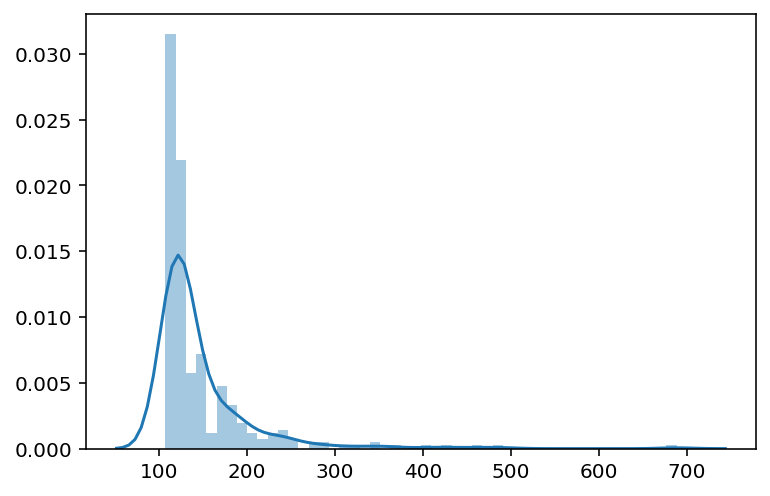

In [129]:
sns.distplot([len(tune) for tune in clean_tunes])

# Write the cleaned result

In [133]:
oneills_df.key.value_counts()

G       129
D       111
Am       29
A        27
Em       20
Ador     11
Amix     10
Dmix      5
C         4
Ddor      3
Gm        3
Bm        2
F         2
Edor      2
Dm        2
Gdor      1
Name: key, dtype: int64

In [136]:
filepath = Path(data_path, "oneills_reformat.abc")
with open(str(filepath), "w") as fh:
    for idx, row in oneills_df.iterrows():
        fh.write("M:6/8\n")
        key = row["key"]
        if len(key) == 1:
            key_str = 'maj'
        elif len(key) == 2:
            key_str = 'min'
        else:
            key_str = key[1:]
        fh.write(f"K:{key_str}\n")
        tune = row["clean_tune"]
        fh.write(f"{' '.join(tune)}\n\n")

# Read dataset

In [138]:
dataset = ABCDataset(filepath)

In [139]:
print(dataset)

vocabulary size: 52
vocabulary (each token separated by a space): 
<pad> <unk> <s> </s> (3 /2 /4 2 3 3/4 :| < =A =B =C =D =F =G =a =b =c =c' =d =d' =e =f =f' =g =g' > K:dor K:maj K:min K:mix M:6/8 [ ] ^A ^A, ^D ^G ^a ^c ^d ^d' ^f ^g z | |1 |2 |:
dataset_size: 361
tune length stats:
	* max 692
	* mean 150.42659279778394
	* median 127.0
	* min 111


# Extra: music21 built-in plots

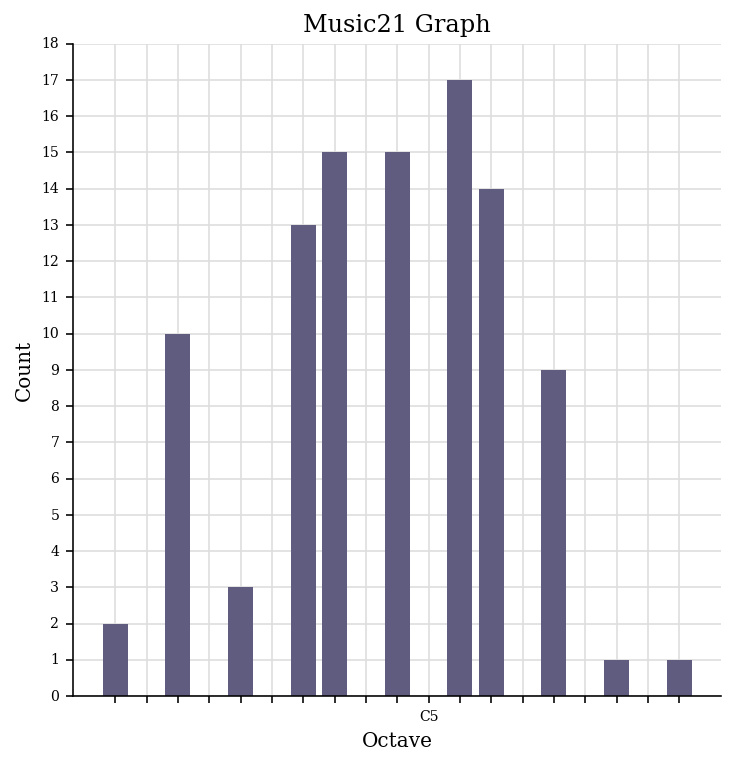

In [36]:
score.plot('histogram', 'octave', xHideUnused=False)

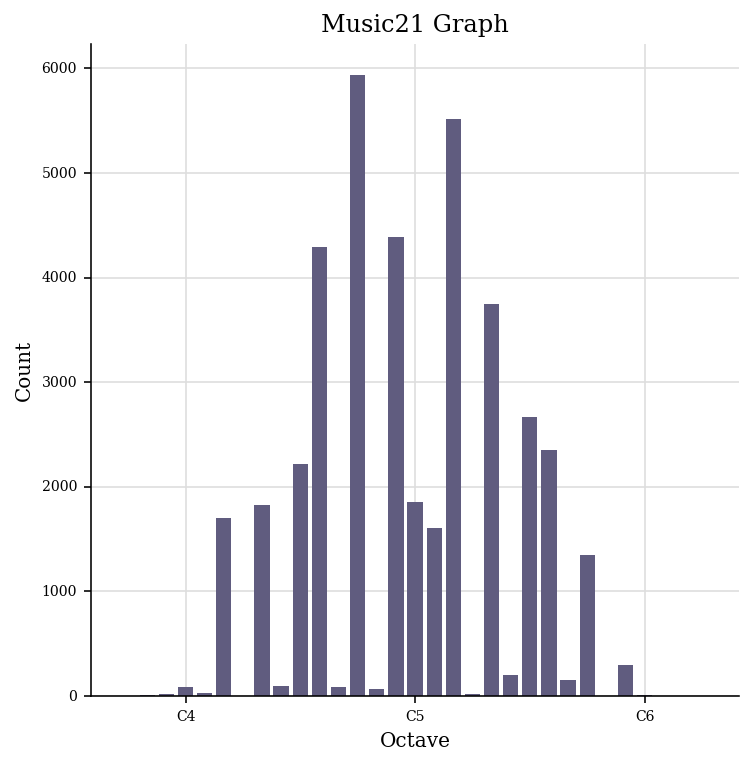

In [37]:
oneills_opus.plot('histogram', 'octave')

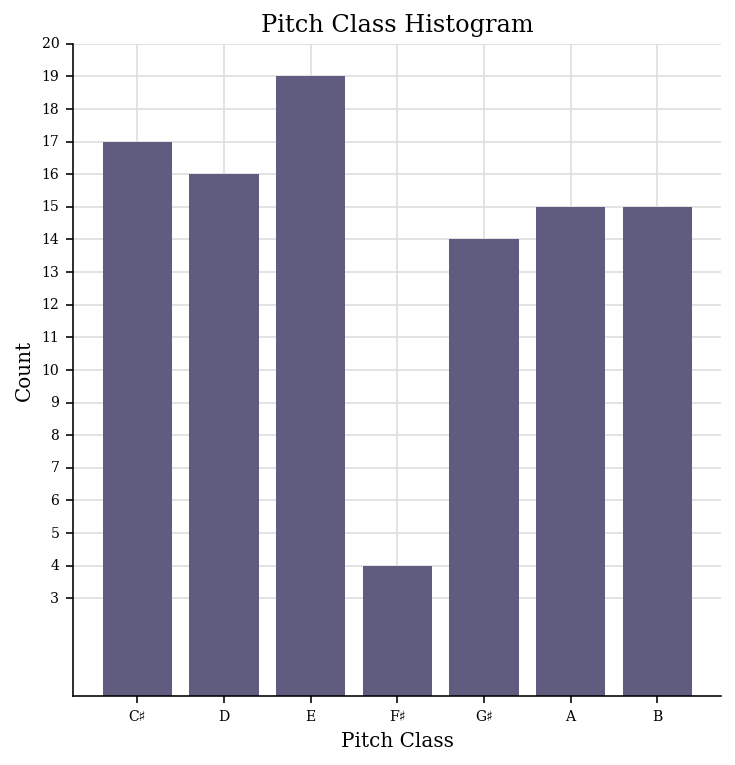

In [38]:
score.plot('histogram', 'pitchClass')

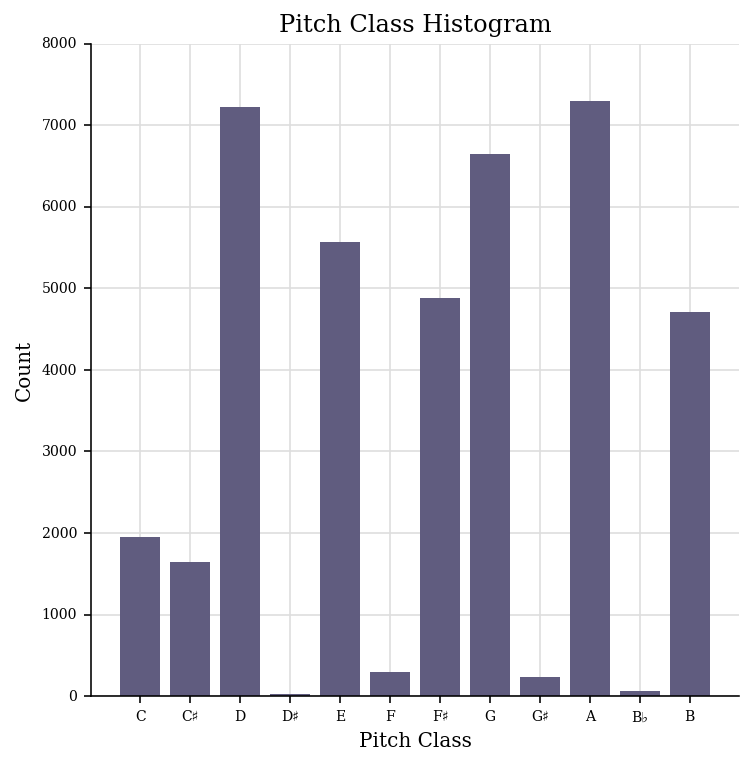

In [39]:
oneills_opus.plot('histogram', 'pitchClass')

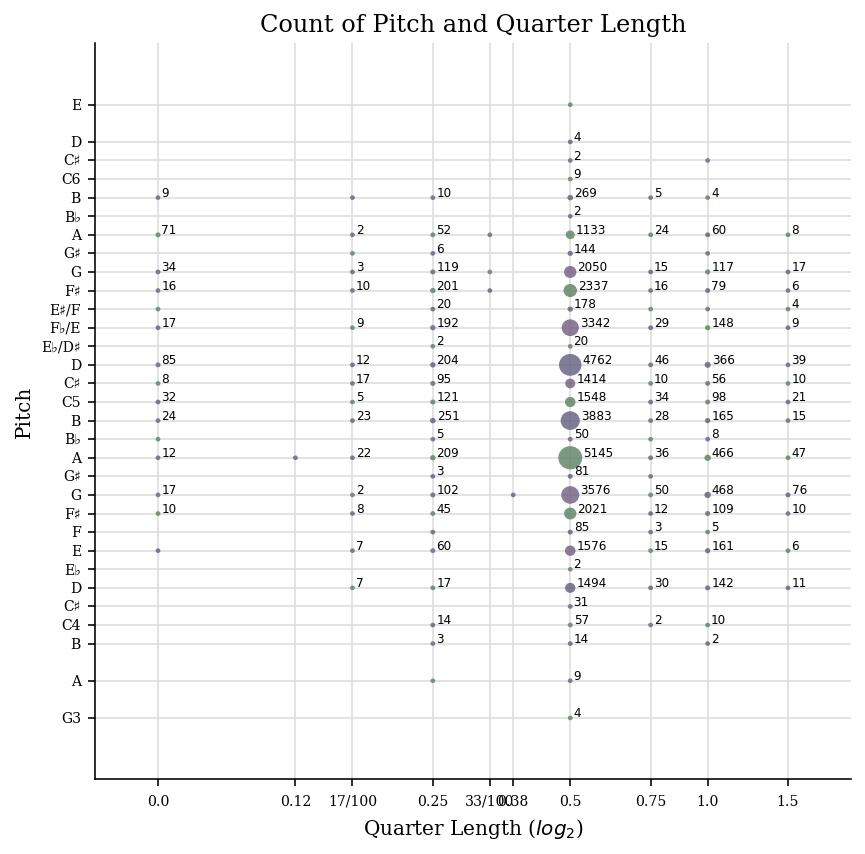

In [40]:
oneills_opus.plot('scatterweighted', 'pitch', 'quarterLength')

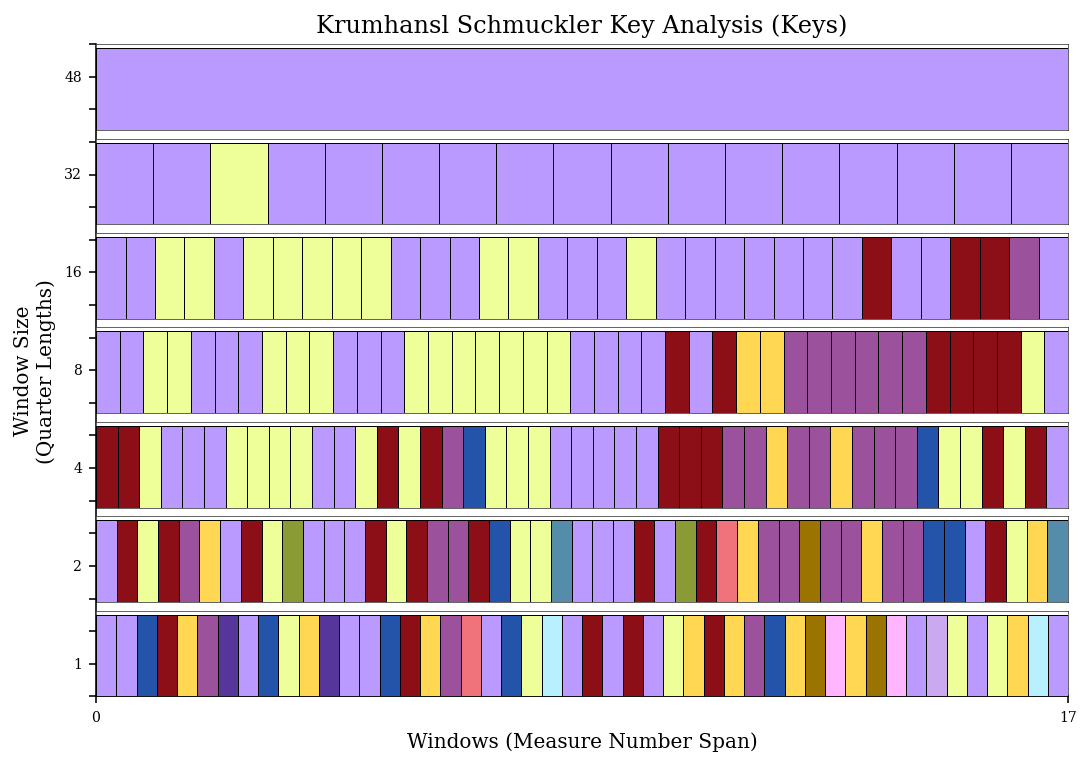

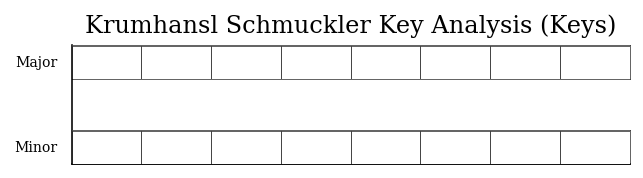

In [41]:
p = music21.graph.plot.WindowedKey(score)
p.run()